In [185]:
import librosa
from pydub import AudioSegment
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential, load_model
from keras.utils import to_categorical
import tensorflow.keras as keras
import visualkeras
import json
import math

## Warning

<b>Before you move any further, be caution.</b>

The data was taken from the Kaggle and was too large to include in the assignmnet: even the pre-processed final zip file was 172 Mb large. Furthermore, I ran into the same problem with my personal data: the output was just too big. 

## Introduction

For this assignment, I would be continuing the task that I did for my last assignment: <b> Music genre identification</b>. Last time I used a simple feed-forward neural network, but this time I would be working with <b> CNN </b>. Moreover, the input data would also be different this time, instead of using my own data for model training and validation, I would be using the famous GTZAN music dataset: personal data would be used to test the model, vice versa of what I did last time. 

## Class Distribution

The music samples taken for training the model are from the GTZAN dataset, which is sometimes called the MNIST of music. The data is a collection of 10 music genres, with 100 audio files for each - each song is 30 seconds long. The tracks are all 22050Hz Mono 16-bit audio files in .wav format. The genres are:

- Blues
- Classical
- Country
- Disco
- Hip-hop
- Jazz
- Metal
- Pop
- Reggae
- Rock

The pie chart below helps visually represent the class distribution of the songs. The equal class distribution is a desirable characteristic of the data set as it helps avoid any biases in the model’s final prediction because there isn't a particular class that the model might get biased to due to its dominance in sample size. For example, if we had 4 times as much hip-hop data as the other songs, the model may become biased towards classifying songs as hip-hop because it has seen more examples of that: this can be prevented by using numerous techniques like using synthetic data, oversampling, or randomly sampling data so that it represents equally in the training set. 


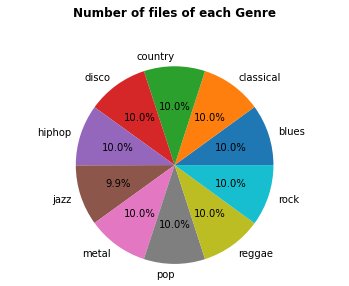

In [68]:
# Generates the Class distribution for the data

parent_dir_path =r"D:\data\genres_original"
labels = []
sizes = []

# Walk through all sub-directories
for dirpath, dirnames, filenames in os.walk(parent_dir_path):
    # Check if there are any files in the directory
    if len(filenames) > 0:
        # Get number of files in the directory
        num_files = len(filenames)

        # Add directory label and number of files to lists
        final = os.path.basename(dirpath)
        labels.append(f"{final}")
        sizes.append(num_files)

# Plot pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')

plt.title('Number of files of each Genre', pad = 40, fontweight='bold')
plt.show()



## Data Visualization

Next, we move on to visualize our data. As we are working with audio data, the best way to visualize our samples is in the form of a waveform. An example of what this looks like is provided below. 

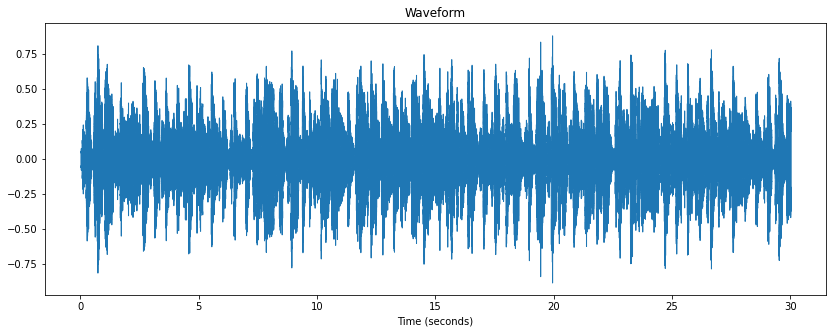

661794

In [241]:
#Single File

filename = r"D:\data\genres_original\blues\blues.00000.wav"

y, sr = librosa.load(filename)

# Plot waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (seconds)')
plt.show()


Finally, we try to see what the waveform of a sample from each of the genres looks like, allowing us to see any visual differences. After looking at the waveforms it is evident that the data is not easily distinguishable, meaning further pre-processing steps are required to extract features that would make each genre differentiable. 

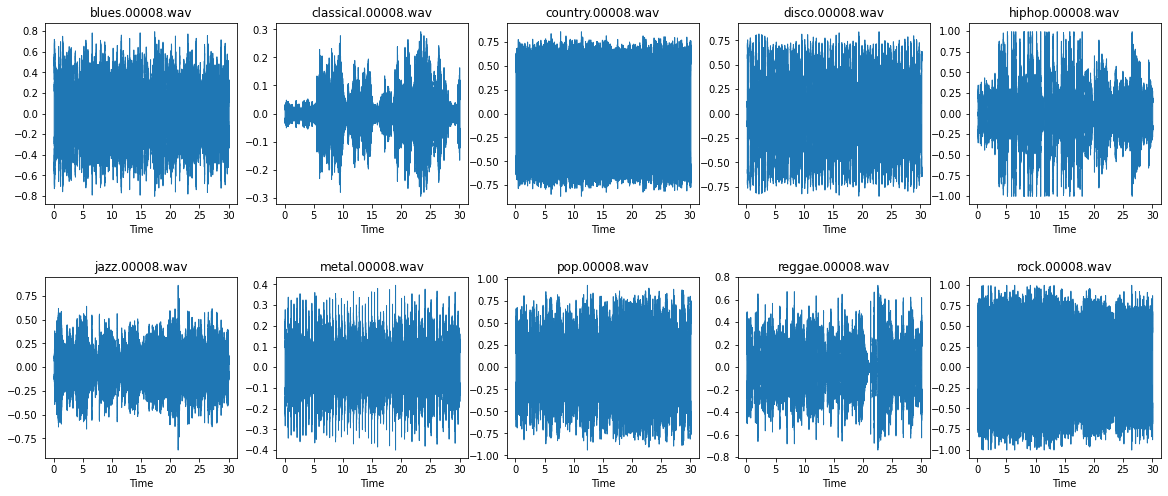

In [70]:
#Multiple Files

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Loop through each directory in the parent directory
subplot_index = 0
for dirpath, dirnames, filenames in os.walk(parent_dir_path):
    # Check if there are any files in the directory
    if len(filenames) > 0:
        # Choose the first file in the directory
        first_file = os.path.join(dirpath, filenames[8])
        y, sr = librosa.load(first_file)

        # Get the filename from the full path
        file_name = os.path.basename(first_file)

        # Plot waveform in a subplot
        row_index = subplot_index // 5
        col_index = subplot_index % 5
        axs[row_index, col_index].set_title(file_name)
        axs[row_index, col_index].set_xlabel('Time (seconds)')
        librosa.display.waveshow(y, sr=sr, ax=axs[row_index, col_index])

        # Increment the subplot index
        subplot_index += 1

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Show the figure
plt.show()

## Fourier Transform

The Fourier transform is a technique used to transform a signal from the time domain to the frequency domain. Meaning that it allows us to represent a signal as a sum of sinusoidal waves of different frequencies. This allows us to decompose the complex sounds of the sample and showcase how different frequencies are contributing to that. Furthermore, it allows for the compression of the sample as we are able to identify the most important frequency components, so we can compress the signal and save computation time while minimizing the loss of important information.


The formula for the Fourier Transform is given below:

$$F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i\omega t} dt$$

- $F(\omega)$ = It is the Fourier Transform of $f(t)$
<br>
- $i$ = Imaginary number
<br>
- $\omega$ = Angular frequency

The formula expresses the signal $f(t)$ as a sum of complex exponential functions of different frequencies. The exponential functions $e^{(-iωt)}$ represent sinusoidal waves with frequency $\omega$ , and the Fourier transform $F(\omega)$ gives us the amplitude and phase of each frequency component of the signal. Finally, the integral represents the weighted sum of all the frequency components: the wieght is given by the value of $f(t)$ at each point in time. The negative sign in the exponent is important is it ensures that frequency components with positive angular frequency corresponding to waves propogating forward, while those with a negative angular frequency correspond to waves propogating backwards.

Below we can see how the waveform is represented in a Spectrogram after we apply the Fourier Transform to the waveform. We can see that the signal has shifted from a time domain to a frequency domain.. This is a problem as now we are unable to see how the data changes through time because, ofcourse music data doesnt remain stationary, and we want to know how data changes through time. To solve this problem we can use the <b> Short Time Fourier Transform </b>.

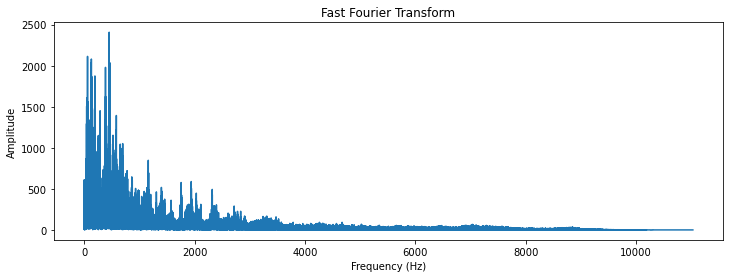

In [71]:
#Converting to a Fast Fourier Graph

y, sr = librosa.load(filename)

# Calculate the FFT
fft = np.fft.fft(y)

# calculate the magnitute
magnitude = np.abs(fft)

#calculate the frequency
frequency = np.linspace(0,sr,len(magnitude))

left_magnitude =magnitude[:int(len(frequency)/2)]
left_frequency = frequency[:int(len(frequency)/2)]
# Calculate the frequency bins
#freq_bins = np.fft.fftfreq(len(y), 1/sr)

# Plot the FFT
plt.figure(figsize=(12, 4))
plt.plot(left_frequency,left_magnitude)
#plt.plot(freq_bins[:len(freq_bins)//2], np.abs(fft)[:len(freq_bins)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fast Fourier Transform')
plt.show()

## Spectrogram

The Short Time Fourier Transform is a technique which breaks down an audio sample into smaller sections, and applies the Fourier Transform on each one, allowing us to capture the time aspect of the sample along with the frequencies. We can imagine this process as placing a small frame over the audio sample and then moving if from one end to the other, and for each frame calculating the Fourier Transform. In the end the result of all the segments is stiched together to form a spectogram. The advantage of using a spectogram is that it provides a quick and easy way of visualizing the changes in frequency content of the signal over time, thus now we have both the time and frequency components. The spectogram has time on the x-axis, frequency on the y-axis, and the magnitude as the color intensity. 


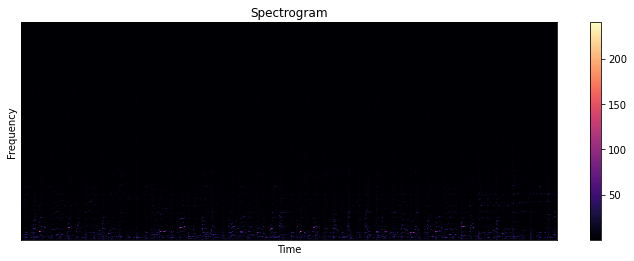

In [72]:
# Spectrogram (STFT)
hop_length = 512 # num. of samples - how much we slide the window to the right after each iteration
n_fft = 2048 # num. of samples for window

# Perform STFT
stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)


# Calculate the Magnitude (abs values on complex numbers)
spectrogram = np.abs(stft)


# Plot the Spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")
plt.show()

## Mel-scale Filterbank

The mel-scale filterbanks are a set of filters that allows us to represent frequencies in a way that are more conssisten with human perception: lower frequencies are better percieved than the higher ones. The filterbank consists of a series of overlapping triangular filters that are blaced on the mel-frequency doman. Each filter corresponds to a different frequency band and the filter output is scaled by taking the log of each band: lower frequencies get more prominent.

C:\Users\DELL\AppData\Roaming\Python\Python38\site-packages\librosa\display.py:1381: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  scaler(mode, **kwargs)


Text(0.5, 1.0, 'Mel-Spectrogram (dB)')

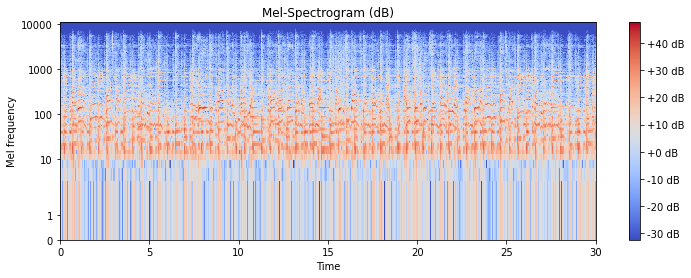

In [74]:

#Mel-Scale filterbank is generated
mel_filterbank = librosa.filters.mel(sr=sr, n_fft=n_fft)

#Mel-Scale filterbank is applied to the Spectrogram using matrix multiplication
mel_spectrogram = mel_filterbank.dot(spectrogram)

# Plot the Mel-Spectrogram in Decibels
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.xlabel("Time")
plt.ylabel("Mel frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram (dB)")

## Mel Frequency Cepstrum Coefficients

After applying the Mel-scale filterbanks and taking the log of the output, we apply a Discrete Cosine transform to the spectrem to obtain a set of cepstral coeffecients. These coeffecients capture te information about the shape of the specctrum of the signal. 

Text(0.5, 1.0, 'MFCCs')

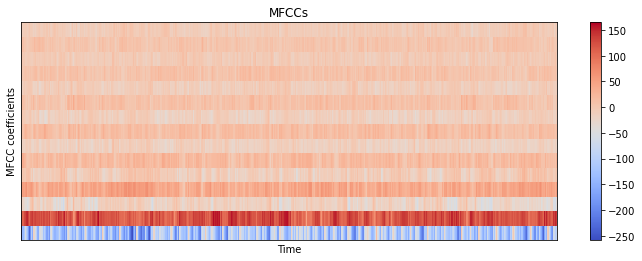

In [75]:
MFCCs = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=16)
plt.figure(figsize=(12, 4))
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

## Feature Extraction

In [101]:
JSON_PATH = "final_dataset.json"
parent_dir_path =r"D:\data\genres_original"
SAMPLE_RATE = sr
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION



In [102]:
def save_mfcc(dataset_path, json_path, num_mfcc=16, n_fft=2048, hop_length=512, num_segments=10):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
    
    inputs
        dataset_path: Path to where the data is located
        json_path: Path where the json file should be created
        num_mfcc: Number of mfcc values to be extracted
        n_fft: Number of samples in each STFT window
        hop_length: Distance window moves after each iteration
        num_segments: Sub-divisions of each sample
        
    Output:
        json_file: Json file with the following infromation:
            mapping = Genre names
            labels = Hot-encoding of genre names
            mfcc = MFCC values
    
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
     

In [103]:
save_mfcc(parent_dir_path, JSON_PATH)


Processing: D:\data\genres_original\blues
D:\data\genres_original\blues\blues.00000.wav, segment:1
D:\data\genres_original\blues\blues.00000.wav, segment:2
D:\data\genres_original\blues\blues.00000.wav, segment:3
D:\data\genres_original\blues\blues.00000.wav, segment:4
D:\data\genres_original\blues\blues.00000.wav, segment:5
D:\data\genres_original\blues\blues.00000.wav, segment:6
D:\data\genres_original\blues\blues.00000.wav, segment:7
D:\data\genres_original\blues\blues.00000.wav, segment:8
D:\data\genres_original\blues\blues.00000.wav, segment:9
D:\data\genres_original\blues\blues.00000.wav, segment:10
D:\data\genres_original\blues\blues.00001.wav, segment:1
D:\data\genres_original\blues\blues.00001.wav, segment:2
D:\data\genres_original\blues\blues.00001.wav, segment:3
D:\data\genres_original\blues\blues.00001.wav, segment:4
D:\data\genres_original\blues\blues.00001.wav, segment:5
D:\data\genres_original\blues\blues.00001.wav, segment:6
D:\data\genres_original\blues\blues.00001.wa

D:\data\genres_original\blues\blues.00015.wav, segment:1
D:\data\genres_original\blues\blues.00015.wav, segment:2
D:\data\genres_original\blues\blues.00015.wav, segment:3
D:\data\genres_original\blues\blues.00015.wav, segment:4
D:\data\genres_original\blues\blues.00015.wav, segment:5
D:\data\genres_original\blues\blues.00015.wav, segment:6
D:\data\genres_original\blues\blues.00015.wav, segment:7
D:\data\genres_original\blues\blues.00015.wav, segment:8
D:\data\genres_original\blues\blues.00015.wav, segment:9
D:\data\genres_original\blues\blues.00015.wav, segment:10
D:\data\genres_original\blues\blues.00016.wav, segment:1
D:\data\genres_original\blues\blues.00016.wav, segment:2
D:\data\genres_original\blues\blues.00016.wav, segment:3
D:\data\genres_original\blues\blues.00016.wav, segment:4
D:\data\genres_original\blues\blues.00016.wav, segment:5
D:\data\genres_original\blues\blues.00016.wav, segment:6
D:\data\genres_original\blues\blues.00016.wav, segment:7
D:\data\genres_original\blues\

D:\data\genres_original\blues\blues.00031.wav, segment:1
D:\data\genres_original\blues\blues.00031.wav, segment:2
D:\data\genres_original\blues\blues.00031.wav, segment:3
D:\data\genres_original\blues\blues.00031.wav, segment:4
D:\data\genres_original\blues\blues.00031.wav, segment:5
D:\data\genres_original\blues\blues.00031.wav, segment:6
D:\data\genres_original\blues\blues.00031.wav, segment:7
D:\data\genres_original\blues\blues.00031.wav, segment:8
D:\data\genres_original\blues\blues.00031.wav, segment:9
D:\data\genres_original\blues\blues.00031.wav, segment:10
D:\data\genres_original\blues\blues.00032.wav, segment:1
D:\data\genres_original\blues\blues.00032.wav, segment:2
D:\data\genres_original\blues\blues.00032.wav, segment:3
D:\data\genres_original\blues\blues.00032.wav, segment:4
D:\data\genres_original\blues\blues.00032.wav, segment:5
D:\data\genres_original\blues\blues.00032.wav, segment:6
D:\data\genres_original\blues\blues.00032.wav, segment:7
D:\data\genres_original\blues\

D:\data\genres_original\blues\blues.00047.wav, segment:5
D:\data\genres_original\blues\blues.00047.wav, segment:6
D:\data\genres_original\blues\blues.00047.wav, segment:7
D:\data\genres_original\blues\blues.00047.wav, segment:8
D:\data\genres_original\blues\blues.00047.wav, segment:9
D:\data\genres_original\blues\blues.00047.wav, segment:10
D:\data\genres_original\blues\blues.00048.wav, segment:1
D:\data\genres_original\blues\blues.00048.wav, segment:2
D:\data\genres_original\blues\blues.00048.wav, segment:3
D:\data\genres_original\blues\blues.00048.wav, segment:4
D:\data\genres_original\blues\blues.00048.wav, segment:5
D:\data\genres_original\blues\blues.00048.wav, segment:6
D:\data\genres_original\blues\blues.00048.wav, segment:7
D:\data\genres_original\blues\blues.00048.wav, segment:8
D:\data\genres_original\blues\blues.00048.wav, segment:9
D:\data\genres_original\blues\blues.00048.wav, segment:10
D:\data\genres_original\blues\blues.00049.wav, segment:1
D:\data\genres_original\blues

D:\data\genres_original\blues\blues.00063.wav, segment:9
D:\data\genres_original\blues\blues.00063.wav, segment:10
D:\data\genres_original\blues\blues.00064.wav, segment:1
D:\data\genres_original\blues\blues.00064.wav, segment:2
D:\data\genres_original\blues\blues.00064.wav, segment:3
D:\data\genres_original\blues\blues.00064.wav, segment:4
D:\data\genres_original\blues\blues.00064.wav, segment:5
D:\data\genres_original\blues\blues.00064.wav, segment:6
D:\data\genres_original\blues\blues.00064.wav, segment:7
D:\data\genres_original\blues\blues.00064.wav, segment:8
D:\data\genres_original\blues\blues.00064.wav, segment:9
D:\data\genres_original\blues\blues.00064.wav, segment:10
D:\data\genres_original\blues\blues.00065.wav, segment:1
D:\data\genres_original\blues\blues.00065.wav, segment:2
D:\data\genres_original\blues\blues.00065.wav, segment:3
D:\data\genres_original\blues\blues.00065.wav, segment:4
D:\data\genres_original\blues\blues.00065.wav, segment:5
D:\data\genres_original\blues

D:\data\genres_original\blues\blues.00080.wav, segment:2
D:\data\genres_original\blues\blues.00080.wav, segment:3
D:\data\genres_original\blues\blues.00080.wav, segment:4
D:\data\genres_original\blues\blues.00080.wav, segment:5
D:\data\genres_original\blues\blues.00080.wav, segment:6
D:\data\genres_original\blues\blues.00080.wav, segment:7
D:\data\genres_original\blues\blues.00080.wav, segment:8
D:\data\genres_original\blues\blues.00080.wav, segment:9
D:\data\genres_original\blues\blues.00080.wav, segment:10
D:\data\genres_original\blues\blues.00081.wav, segment:1
D:\data\genres_original\blues\blues.00081.wav, segment:2
D:\data\genres_original\blues\blues.00081.wav, segment:3
D:\data\genres_original\blues\blues.00081.wav, segment:4
D:\data\genres_original\blues\blues.00081.wav, segment:5
D:\data\genres_original\blues\blues.00081.wav, segment:6
D:\data\genres_original\blues\blues.00081.wav, segment:7
D:\data\genres_original\blues\blues.00081.wav, segment:8
D:\data\genres_original\blues\

D:\data\genres_original\blues\blues.00096.wav, segment:1
D:\data\genres_original\blues\blues.00096.wav, segment:2
D:\data\genres_original\blues\blues.00096.wav, segment:3
D:\data\genres_original\blues\blues.00096.wav, segment:4
D:\data\genres_original\blues\blues.00096.wav, segment:5
D:\data\genres_original\blues\blues.00096.wav, segment:6
D:\data\genres_original\blues\blues.00096.wav, segment:7
D:\data\genres_original\blues\blues.00096.wav, segment:8
D:\data\genres_original\blues\blues.00096.wav, segment:9
D:\data\genres_original\blues\blues.00096.wav, segment:10
D:\data\genres_original\blues\blues.00097.wav, segment:1
D:\data\genres_original\blues\blues.00097.wav, segment:2
D:\data\genres_original\blues\blues.00097.wav, segment:3
D:\data\genres_original\blues\blues.00097.wav, segment:4
D:\data\genres_original\blues\blues.00097.wav, segment:5
D:\data\genres_original\blues\blues.00097.wav, segment:6
D:\data\genres_original\blues\blues.00097.wav, segment:7
D:\data\genres_original\blues\

D:\data\genres_original\classical\classical.00009.wav, segment:5
D:\data\genres_original\classical\classical.00009.wav, segment:6
D:\data\genres_original\classical\classical.00009.wav, segment:7
D:\data\genres_original\classical\classical.00009.wav, segment:8
D:\data\genres_original\classical\classical.00009.wav, segment:9
D:\data\genres_original\classical\classical.00009.wav, segment:10
D:\data\genres_original\classical\classical.00010.wav, segment:1
D:\data\genres_original\classical\classical.00010.wav, segment:2
D:\data\genres_original\classical\classical.00010.wav, segment:3
D:\data\genres_original\classical\classical.00010.wav, segment:4
D:\data\genres_original\classical\classical.00010.wav, segment:5
D:\data\genres_original\classical\classical.00010.wav, segment:6
D:\data\genres_original\classical\classical.00010.wav, segment:7
D:\data\genres_original\classical\classical.00010.wav, segment:8
D:\data\genres_original\classical\classical.00010.wav, segment:9
D:\data\genres_original\

D:\data\genres_original\classical\classical.00023.wav, segment:1
D:\data\genres_original\classical\classical.00023.wav, segment:2
D:\data\genres_original\classical\classical.00023.wav, segment:3
D:\data\genres_original\classical\classical.00023.wav, segment:4
D:\data\genres_original\classical\classical.00023.wav, segment:5
D:\data\genres_original\classical\classical.00023.wav, segment:6
D:\data\genres_original\classical\classical.00023.wav, segment:7
D:\data\genres_original\classical\classical.00023.wav, segment:8
D:\data\genres_original\classical\classical.00023.wav, segment:9
D:\data\genres_original\classical\classical.00023.wav, segment:10
D:\data\genres_original\classical\classical.00024.wav, segment:1
D:\data\genres_original\classical\classical.00024.wav, segment:2
D:\data\genres_original\classical\classical.00024.wav, segment:3
D:\data\genres_original\classical\classical.00024.wav, segment:4
D:\data\genres_original\classical\classical.00024.wav, segment:5
D:\data\genres_original\

D:\data\genres_original\classical\classical.00036.wav, segment:9
D:\data\genres_original\classical\classical.00036.wav, segment:10
D:\data\genres_original\classical\classical.00037.wav, segment:1
D:\data\genres_original\classical\classical.00037.wav, segment:2
D:\data\genres_original\classical\classical.00037.wav, segment:3
D:\data\genres_original\classical\classical.00037.wav, segment:4
D:\data\genres_original\classical\classical.00037.wav, segment:5
D:\data\genres_original\classical\classical.00037.wav, segment:6
D:\data\genres_original\classical\classical.00037.wav, segment:7
D:\data\genres_original\classical\classical.00037.wav, segment:8
D:\data\genres_original\classical\classical.00037.wav, segment:9
D:\data\genres_original\classical\classical.00037.wav, segment:10
D:\data\genres_original\classical\classical.00038.wav, segment:1
D:\data\genres_original\classical\classical.00038.wav, segment:2
D:\data\genres_original\classical\classical.00038.wav, segment:3
D:\data\genres_original

D:\data\genres_original\classical\classical.00049.wav, segment:5
D:\data\genres_original\classical\classical.00049.wav, segment:6
D:\data\genres_original\classical\classical.00049.wav, segment:7
D:\data\genres_original\classical\classical.00049.wav, segment:8
D:\data\genres_original\classical\classical.00049.wav, segment:9
D:\data\genres_original\classical\classical.00049.wav, segment:10
D:\data\genres_original\classical\classical.00050.wav, segment:1
D:\data\genres_original\classical\classical.00050.wav, segment:2
D:\data\genres_original\classical\classical.00050.wav, segment:3
D:\data\genres_original\classical\classical.00050.wav, segment:4
D:\data\genres_original\classical\classical.00050.wav, segment:5
D:\data\genres_original\classical\classical.00050.wav, segment:6
D:\data\genres_original\classical\classical.00050.wav, segment:7
D:\data\genres_original\classical\classical.00050.wav, segment:8
D:\data\genres_original\classical\classical.00050.wav, segment:9
D:\data\genres_original\

D:\data\genres_original\classical\classical.00063.wav, segment:6
D:\data\genres_original\classical\classical.00063.wav, segment:7
D:\data\genres_original\classical\classical.00063.wav, segment:8
D:\data\genres_original\classical\classical.00063.wav, segment:9
D:\data\genres_original\classical\classical.00063.wav, segment:10
D:\data\genres_original\classical\classical.00064.wav, segment:1
D:\data\genres_original\classical\classical.00064.wav, segment:2
D:\data\genres_original\classical\classical.00064.wav, segment:3
D:\data\genres_original\classical\classical.00064.wav, segment:4
D:\data\genres_original\classical\classical.00064.wav, segment:5
D:\data\genres_original\classical\classical.00064.wav, segment:6
D:\data\genres_original\classical\classical.00064.wav, segment:7
D:\data\genres_original\classical\classical.00064.wav, segment:8
D:\data\genres_original\classical\classical.00064.wav, segment:9
D:\data\genres_original\classical\classical.00064.wav, segment:10
D:\data\genres_original

D:\data\genres_original\classical\classical.00077.wav, segment:2
D:\data\genres_original\classical\classical.00077.wav, segment:3
D:\data\genres_original\classical\classical.00077.wav, segment:4
D:\data\genres_original\classical\classical.00077.wav, segment:5
D:\data\genres_original\classical\classical.00077.wav, segment:6
D:\data\genres_original\classical\classical.00077.wav, segment:7
D:\data\genres_original\classical\classical.00077.wav, segment:8
D:\data\genres_original\classical\classical.00077.wav, segment:9
D:\data\genres_original\classical\classical.00077.wav, segment:10
D:\data\genres_original\classical\classical.00078.wav, segment:1
D:\data\genres_original\classical\classical.00078.wav, segment:2
D:\data\genres_original\classical\classical.00078.wav, segment:3
D:\data\genres_original\classical\classical.00078.wav, segment:4
D:\data\genres_original\classical\classical.00078.wav, segment:5
D:\data\genres_original\classical\classical.00078.wav, segment:6
D:\data\genres_original\

D:\data\genres_original\classical\classical.00090.wav, segment:8
D:\data\genres_original\classical\classical.00090.wav, segment:9
D:\data\genres_original\classical\classical.00090.wav, segment:10
D:\data\genres_original\classical\classical.00091.wav, segment:1
D:\data\genres_original\classical\classical.00091.wav, segment:2
D:\data\genres_original\classical\classical.00091.wav, segment:3
D:\data\genres_original\classical\classical.00091.wav, segment:4
D:\data\genres_original\classical\classical.00091.wav, segment:5
D:\data\genres_original\classical\classical.00091.wav, segment:6
D:\data\genres_original\classical\classical.00091.wav, segment:7
D:\data\genres_original\classical\classical.00091.wav, segment:8
D:\data\genres_original\classical\classical.00091.wav, segment:9
D:\data\genres_original\classical\classical.00091.wav, segment:10
D:\data\genres_original\classical\classical.00092.wav, segment:1
D:\data\genres_original\classical\classical.00092.wav, segment:2
D:\data\genres_original

D:\data\genres_original\country\country.00004.wav, segment:4
D:\data\genres_original\country\country.00004.wav, segment:5
D:\data\genres_original\country\country.00004.wav, segment:6
D:\data\genres_original\country\country.00004.wav, segment:7
D:\data\genres_original\country\country.00004.wav, segment:8
D:\data\genres_original\country\country.00004.wav, segment:9
D:\data\genres_original\country\country.00004.wav, segment:10
D:\data\genres_original\country\country.00005.wav, segment:1
D:\data\genres_original\country\country.00005.wav, segment:2
D:\data\genres_original\country\country.00005.wav, segment:3
D:\data\genres_original\country\country.00005.wav, segment:4
D:\data\genres_original\country\country.00005.wav, segment:5
D:\data\genres_original\country\country.00005.wav, segment:6
D:\data\genres_original\country\country.00005.wav, segment:7
D:\data\genres_original\country\country.00005.wav, segment:8
D:\data\genres_original\country\country.00005.wav, segment:9
D:\data\genres_original

D:\data\genres_original\country\country.00018.wav, segment:4
D:\data\genres_original\country\country.00018.wav, segment:5
D:\data\genres_original\country\country.00018.wav, segment:6
D:\data\genres_original\country\country.00018.wav, segment:7
D:\data\genres_original\country\country.00018.wav, segment:8
D:\data\genres_original\country\country.00018.wav, segment:9
D:\data\genres_original\country\country.00018.wav, segment:10
D:\data\genres_original\country\country.00019.wav, segment:1
D:\data\genres_original\country\country.00019.wav, segment:2
D:\data\genres_original\country\country.00019.wav, segment:3
D:\data\genres_original\country\country.00019.wav, segment:4
D:\data\genres_original\country\country.00019.wav, segment:5
D:\data\genres_original\country\country.00019.wav, segment:6
D:\data\genres_original\country\country.00019.wav, segment:7
D:\data\genres_original\country\country.00019.wav, segment:8
D:\data\genres_original\country\country.00019.wav, segment:9
D:\data\genres_original

D:\data\genres_original\country\country.00031.wav, segment:9
D:\data\genres_original\country\country.00031.wav, segment:10
D:\data\genres_original\country\country.00032.wav, segment:1
D:\data\genres_original\country\country.00032.wav, segment:2
D:\data\genres_original\country\country.00032.wav, segment:3
D:\data\genres_original\country\country.00032.wav, segment:4
D:\data\genres_original\country\country.00032.wav, segment:5
D:\data\genres_original\country\country.00032.wav, segment:6
D:\data\genres_original\country\country.00032.wav, segment:7
D:\data\genres_original\country\country.00032.wav, segment:8
D:\data\genres_original\country\country.00032.wav, segment:9
D:\data\genres_original\country\country.00032.wav, segment:10
D:\data\genres_original\country\country.00033.wav, segment:1
D:\data\genres_original\country\country.00033.wav, segment:2
D:\data\genres_original\country\country.00033.wav, segment:3
D:\data\genres_original\country\country.00033.wav, segment:4
D:\data\genres_origina

D:\data\genres_original\country\country.00046.wav, segment:7
D:\data\genres_original\country\country.00046.wav, segment:8
D:\data\genres_original\country\country.00046.wav, segment:9
D:\data\genres_original\country\country.00046.wav, segment:10
D:\data\genres_original\country\country.00047.wav, segment:1
D:\data\genres_original\country\country.00047.wav, segment:2
D:\data\genres_original\country\country.00047.wav, segment:3
D:\data\genres_original\country\country.00047.wav, segment:4
D:\data\genres_original\country\country.00047.wav, segment:5
D:\data\genres_original\country\country.00047.wav, segment:6
D:\data\genres_original\country\country.00047.wav, segment:7
D:\data\genres_original\country\country.00047.wav, segment:8
D:\data\genres_original\country\country.00047.wav, segment:9
D:\data\genres_original\country\country.00047.wav, segment:10
D:\data\genres_original\country\country.00048.wav, segment:1
D:\data\genres_original\country\country.00048.wav, segment:2
D:\data\genres_origina

D:\data\genres_original\country\country.00060.wav, segment:4
D:\data\genres_original\country\country.00060.wav, segment:5
D:\data\genres_original\country\country.00060.wav, segment:6
D:\data\genres_original\country\country.00060.wav, segment:7
D:\data\genres_original\country\country.00060.wav, segment:8
D:\data\genres_original\country\country.00060.wav, segment:9
D:\data\genres_original\country\country.00060.wav, segment:10
D:\data\genres_original\country\country.00061.wav, segment:1
D:\data\genres_original\country\country.00061.wav, segment:2
D:\data\genres_original\country\country.00061.wav, segment:3
D:\data\genres_original\country\country.00061.wav, segment:4
D:\data\genres_original\country\country.00061.wav, segment:5
D:\data\genres_original\country\country.00061.wav, segment:6
D:\data\genres_original\country\country.00061.wav, segment:7
D:\data\genres_original\country\country.00061.wav, segment:8
D:\data\genres_original\country\country.00061.wav, segment:9
D:\data\genres_original

D:\data\genres_original\country\country.00074.wav, segment:4
D:\data\genres_original\country\country.00074.wav, segment:5
D:\data\genres_original\country\country.00074.wav, segment:6
D:\data\genres_original\country\country.00074.wav, segment:7
D:\data\genres_original\country\country.00074.wav, segment:8
D:\data\genres_original\country\country.00074.wav, segment:9
D:\data\genres_original\country\country.00074.wav, segment:10
D:\data\genres_original\country\country.00075.wav, segment:1
D:\data\genres_original\country\country.00075.wav, segment:2
D:\data\genres_original\country\country.00075.wav, segment:3
D:\data\genres_original\country\country.00075.wav, segment:4
D:\data\genres_original\country\country.00075.wav, segment:5
D:\data\genres_original\country\country.00075.wav, segment:6
D:\data\genres_original\country\country.00075.wav, segment:7
D:\data\genres_original\country\country.00075.wav, segment:8
D:\data\genres_original\country\country.00075.wav, segment:9
D:\data\genres_original

D:\data\genres_original\country\country.00088.wav, segment:4
D:\data\genres_original\country\country.00088.wav, segment:5
D:\data\genres_original\country\country.00088.wav, segment:6
D:\data\genres_original\country\country.00088.wav, segment:7
D:\data\genres_original\country\country.00088.wav, segment:8
D:\data\genres_original\country\country.00088.wav, segment:9
D:\data\genres_original\country\country.00088.wav, segment:10
D:\data\genres_original\country\country.00089.wav, segment:1
D:\data\genres_original\country\country.00089.wav, segment:2
D:\data\genres_original\country\country.00089.wav, segment:3
D:\data\genres_original\country\country.00089.wav, segment:4
D:\data\genres_original\country\country.00089.wav, segment:5
D:\data\genres_original\country\country.00089.wav, segment:6
D:\data\genres_original\country\country.00089.wav, segment:7
D:\data\genres_original\country\country.00089.wav, segment:8
D:\data\genres_original\country\country.00089.wav, segment:9
D:\data\genres_original

D:\data\genres_original\disco\disco.00002.wav, segment:4
D:\data\genres_original\disco\disco.00002.wav, segment:5
D:\data\genres_original\disco\disco.00002.wav, segment:6
D:\data\genres_original\disco\disco.00002.wav, segment:7
D:\data\genres_original\disco\disco.00002.wav, segment:8
D:\data\genres_original\disco\disco.00002.wav, segment:9
D:\data\genres_original\disco\disco.00002.wav, segment:10
D:\data\genres_original\disco\disco.00003.wav, segment:1
D:\data\genres_original\disco\disco.00003.wav, segment:2
D:\data\genres_original\disco\disco.00003.wav, segment:3
D:\data\genres_original\disco\disco.00003.wav, segment:4
D:\data\genres_original\disco\disco.00003.wav, segment:5
D:\data\genres_original\disco\disco.00003.wav, segment:6
D:\data\genres_original\disco\disco.00003.wav, segment:7
D:\data\genres_original\disco\disco.00003.wav, segment:8
D:\data\genres_original\disco\disco.00003.wav, segment:9
D:\data\genres_original\disco\disco.00003.wav, segment:10
D:\data\genres_original\disco

D:\data\genres_original\disco\disco.00019.wav, segment:1
D:\data\genres_original\disco\disco.00019.wav, segment:2
D:\data\genres_original\disco\disco.00019.wav, segment:3
D:\data\genres_original\disco\disco.00019.wav, segment:4
D:\data\genres_original\disco\disco.00019.wav, segment:5
D:\data\genres_original\disco\disco.00019.wav, segment:6
D:\data\genres_original\disco\disco.00019.wav, segment:7
D:\data\genres_original\disco\disco.00019.wav, segment:8
D:\data\genres_original\disco\disco.00019.wav, segment:9
D:\data\genres_original\disco\disco.00019.wav, segment:10
D:\data\genres_original\disco\disco.00020.wav, segment:1
D:\data\genres_original\disco\disco.00020.wav, segment:2
D:\data\genres_original\disco\disco.00020.wav, segment:3
D:\data\genres_original\disco\disco.00020.wav, segment:4
D:\data\genres_original\disco\disco.00020.wav, segment:5
D:\data\genres_original\disco\disco.00020.wav, segment:6
D:\data\genres_original\disco\disco.00020.wav, segment:7
D:\data\genres_original\disco\

D:\data\genres_original\disco\disco.00035.wav, segment:4
D:\data\genres_original\disco\disco.00035.wav, segment:5
D:\data\genres_original\disco\disco.00035.wav, segment:6
D:\data\genres_original\disco\disco.00035.wav, segment:7
D:\data\genres_original\disco\disco.00035.wav, segment:8
D:\data\genres_original\disco\disco.00035.wav, segment:9
D:\data\genres_original\disco\disco.00035.wav, segment:10
D:\data\genres_original\disco\disco.00036.wav, segment:1
D:\data\genres_original\disco\disco.00036.wav, segment:2
D:\data\genres_original\disco\disco.00036.wav, segment:3
D:\data\genres_original\disco\disco.00036.wav, segment:4
D:\data\genres_original\disco\disco.00036.wav, segment:5
D:\data\genres_original\disco\disco.00036.wav, segment:6
D:\data\genres_original\disco\disco.00036.wav, segment:7
D:\data\genres_original\disco\disco.00036.wav, segment:8
D:\data\genres_original\disco\disco.00036.wav, segment:9
D:\data\genres_original\disco\disco.00036.wav, segment:10
D:\data\genres_original\disco

D:\data\genres_original\disco\disco.00049.wav, segment:9
D:\data\genres_original\disco\disco.00049.wav, segment:10
D:\data\genres_original\disco\disco.00050.wav, segment:1
D:\data\genres_original\disco\disco.00050.wav, segment:2
D:\data\genres_original\disco\disco.00050.wav, segment:3
D:\data\genres_original\disco\disco.00050.wav, segment:4
D:\data\genres_original\disco\disco.00050.wav, segment:5
D:\data\genres_original\disco\disco.00050.wav, segment:6
D:\data\genres_original\disco\disco.00050.wav, segment:7
D:\data\genres_original\disco\disco.00050.wav, segment:8
D:\data\genres_original\disco\disco.00050.wav, segment:9
D:\data\genres_original\disco\disco.00050.wav, segment:10
D:\data\genres_original\disco\disco.00051.wav, segment:1
D:\data\genres_original\disco\disco.00051.wav, segment:2
D:\data\genres_original\disco\disco.00051.wav, segment:3
D:\data\genres_original\disco\disco.00051.wav, segment:4
D:\data\genres_original\disco\disco.00051.wav, segment:5
D:\data\genres_original\disco

D:\data\genres_original\disco\disco.00064.wav, segment:9
D:\data\genres_original\disco\disco.00064.wav, segment:10
D:\data\genres_original\disco\disco.00065.wav, segment:1
D:\data\genres_original\disco\disco.00065.wav, segment:2
D:\data\genres_original\disco\disco.00065.wav, segment:3
D:\data\genres_original\disco\disco.00065.wav, segment:4
D:\data\genres_original\disco\disco.00065.wav, segment:5
D:\data\genres_original\disco\disco.00065.wav, segment:6
D:\data\genres_original\disco\disco.00065.wav, segment:7
D:\data\genres_original\disco\disco.00065.wav, segment:8
D:\data\genres_original\disco\disco.00065.wav, segment:9
D:\data\genres_original\disco\disco.00065.wav, segment:10
D:\data\genres_original\disco\disco.00066.wav, segment:1
D:\data\genres_original\disco\disco.00066.wav, segment:2
D:\data\genres_original\disco\disco.00066.wav, segment:3
D:\data\genres_original\disco\disco.00066.wav, segment:4
D:\data\genres_original\disco\disco.00066.wav, segment:5
D:\data\genres_original\disco

D:\data\genres_original\disco\disco.00080.wav, segment:5
D:\data\genres_original\disco\disco.00080.wav, segment:6
D:\data\genres_original\disco\disco.00080.wav, segment:7
D:\data\genres_original\disco\disco.00080.wav, segment:8
D:\data\genres_original\disco\disco.00080.wav, segment:9
D:\data\genres_original\disco\disco.00080.wav, segment:10
D:\data\genres_original\disco\disco.00081.wav, segment:1
D:\data\genres_original\disco\disco.00081.wav, segment:2
D:\data\genres_original\disco\disco.00081.wav, segment:3
D:\data\genres_original\disco\disco.00081.wav, segment:4
D:\data\genres_original\disco\disco.00081.wav, segment:5
D:\data\genres_original\disco\disco.00081.wav, segment:6
D:\data\genres_original\disco\disco.00081.wav, segment:7
D:\data\genres_original\disco\disco.00081.wav, segment:8
D:\data\genres_original\disco\disco.00081.wav, segment:9
D:\data\genres_original\disco\disco.00081.wav, segment:10
D:\data\genres_original\disco\disco.00082.wav, segment:1
D:\data\genres_original\disco

D:\data\genres_original\disco\disco.00096.wav, segment:3
D:\data\genres_original\disco\disco.00096.wav, segment:4
D:\data\genres_original\disco\disco.00096.wav, segment:5
D:\data\genres_original\disco\disco.00096.wav, segment:6
D:\data\genres_original\disco\disco.00096.wav, segment:7
D:\data\genres_original\disco\disco.00096.wav, segment:8
D:\data\genres_original\disco\disco.00096.wav, segment:9
D:\data\genres_original\disco\disco.00096.wav, segment:10
D:\data\genres_original\disco\disco.00097.wav, segment:1
D:\data\genres_original\disco\disco.00097.wav, segment:2
D:\data\genres_original\disco\disco.00097.wav, segment:3
D:\data\genres_original\disco\disco.00097.wav, segment:4
D:\data\genres_original\disco\disco.00097.wav, segment:5
D:\data\genres_original\disco\disco.00097.wav, segment:6
D:\data\genres_original\disco\disco.00097.wav, segment:7
D:\data\genres_original\disco\disco.00097.wav, segment:8
D:\data\genres_original\disco\disco.00097.wav, segment:9
D:\data\genres_original\disco\

D:\data\genres_original\hiphop\hiphop.00011.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00011.wav, segment:3
D:\data\genres_original\hiphop\hiphop.00011.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00011.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00011.wav, segment:6
D:\data\genres_original\hiphop\hiphop.00011.wav, segment:7
D:\data\genres_original\hiphop\hiphop.00011.wav, segment:8
D:\data\genres_original\hiphop\hiphop.00011.wav, segment:9
D:\data\genres_original\hiphop\hiphop.00011.wav, segment:10
D:\data\genres_original\hiphop\hiphop.00012.wav, segment:1
D:\data\genres_original\hiphop\hiphop.00012.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00012.wav, segment:3
D:\data\genres_original\hiphop\hiphop.00012.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00012.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00012.wav, segment:6
D:\data\genres_original\hiphop\hiphop.00012.wav, segment:7
D:\data\genres_original\hiphop\hiphop.00012.wav, segmen

D:\data\genres_original\hiphop\hiphop.00025.wav, segment:10
D:\data\genres_original\hiphop\hiphop.00026.wav, segment:1
D:\data\genres_original\hiphop\hiphop.00026.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00026.wav, segment:3
D:\data\genres_original\hiphop\hiphop.00026.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00026.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00026.wav, segment:6
D:\data\genres_original\hiphop\hiphop.00026.wav, segment:7
D:\data\genres_original\hiphop\hiphop.00026.wav, segment:8
D:\data\genres_original\hiphop\hiphop.00026.wav, segment:9
D:\data\genres_original\hiphop\hiphop.00026.wav, segment:10
D:\data\genres_original\hiphop\hiphop.00027.wav, segment:1
D:\data\genres_original\hiphop\hiphop.00027.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00027.wav, segment:3
D:\data\genres_original\hiphop\hiphop.00027.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00027.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00027.wav, segme

D:\data\genres_original\hiphop\hiphop.00041.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00041.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00041.wav, segment:6
D:\data\genres_original\hiphop\hiphop.00041.wav, segment:7
D:\data\genres_original\hiphop\hiphop.00041.wav, segment:8
D:\data\genres_original\hiphop\hiphop.00041.wav, segment:9
D:\data\genres_original\hiphop\hiphop.00041.wav, segment:10
D:\data\genres_original\hiphop\hiphop.00042.wav, segment:1
D:\data\genres_original\hiphop\hiphop.00042.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00042.wav, segment:3
D:\data\genres_original\hiphop\hiphop.00042.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00042.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00042.wav, segment:6
D:\data\genres_original\hiphop\hiphop.00042.wav, segment:7
D:\data\genres_original\hiphop\hiphop.00042.wav, segment:8
D:\data\genres_original\hiphop\hiphop.00042.wav, segment:9
D:\data\genres_original\hiphop\hiphop.00042.wav, segmen

D:\data\genres_original\hiphop\hiphop.00055.wav, segment:7
D:\data\genres_original\hiphop\hiphop.00055.wav, segment:8
D:\data\genres_original\hiphop\hiphop.00055.wav, segment:9
D:\data\genres_original\hiphop\hiphop.00055.wav, segment:10
D:\data\genres_original\hiphop\hiphop.00056.wav, segment:1
D:\data\genres_original\hiphop\hiphop.00056.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00056.wav, segment:3
D:\data\genres_original\hiphop\hiphop.00056.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00056.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00056.wav, segment:6
D:\data\genres_original\hiphop\hiphop.00056.wav, segment:7
D:\data\genres_original\hiphop\hiphop.00056.wav, segment:8
D:\data\genres_original\hiphop\hiphop.00056.wav, segment:9
D:\data\genres_original\hiphop\hiphop.00056.wav, segment:10
D:\data\genres_original\hiphop\hiphop.00057.wav, segment:1
D:\data\genres_original\hiphop\hiphop.00057.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00057.wav, segme

D:\data\genres_original\hiphop\hiphop.00070.wav, segment:10
D:\data\genres_original\hiphop\hiphop.00071.wav, segment:1
D:\data\genres_original\hiphop\hiphop.00071.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00071.wav, segment:3
D:\data\genres_original\hiphop\hiphop.00071.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00071.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00071.wav, segment:6
D:\data\genres_original\hiphop\hiphop.00071.wav, segment:7
D:\data\genres_original\hiphop\hiphop.00071.wav, segment:8
D:\data\genres_original\hiphop\hiphop.00071.wav, segment:9
D:\data\genres_original\hiphop\hiphop.00071.wav, segment:10
D:\data\genres_original\hiphop\hiphop.00072.wav, segment:1
D:\data\genres_original\hiphop\hiphop.00072.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00072.wav, segment:3
D:\data\genres_original\hiphop\hiphop.00072.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00072.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00072.wav, segme

D:\data\genres_original\hiphop\hiphop.00086.wav, segment:1
D:\data\genres_original\hiphop\hiphop.00086.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00086.wav, segment:3
D:\data\genres_original\hiphop\hiphop.00086.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00086.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00086.wav, segment:6
D:\data\genres_original\hiphop\hiphop.00086.wav, segment:7
D:\data\genres_original\hiphop\hiphop.00086.wav, segment:8
D:\data\genres_original\hiphop\hiphop.00086.wav, segment:9
D:\data\genres_original\hiphop\hiphop.00086.wav, segment:10
D:\data\genres_original\hiphop\hiphop.00087.wav, segment:1
D:\data\genres_original\hiphop\hiphop.00087.wav, segment:2
D:\data\genres_original\hiphop\hiphop.00087.wav, segment:3
D:\data\genres_original\hiphop\hiphop.00087.wav, segment:4
D:\data\genres_original\hiphop\hiphop.00087.wav, segment:5
D:\data\genres_original\hiphop\hiphop.00087.wav, segment:6
D:\data\genres_original\hiphop\hiphop.00087.wav, segmen

D:\data\genres_original\jazz\jazz.00001.wav, segment:2
D:\data\genres_original\jazz\jazz.00001.wav, segment:3
D:\data\genres_original\jazz\jazz.00001.wav, segment:4
D:\data\genres_original\jazz\jazz.00001.wav, segment:5
D:\data\genres_original\jazz\jazz.00001.wav, segment:6
D:\data\genres_original\jazz\jazz.00001.wav, segment:7
D:\data\genres_original\jazz\jazz.00001.wav, segment:8
D:\data\genres_original\jazz\jazz.00001.wav, segment:9
D:\data\genres_original\jazz\jazz.00001.wav, segment:10
D:\data\genres_original\jazz\jazz.00002.wav, segment:1
D:\data\genres_original\jazz\jazz.00002.wav, segment:2
D:\data\genres_original\jazz\jazz.00002.wav, segment:3
D:\data\genres_original\jazz\jazz.00002.wav, segment:4
D:\data\genres_original\jazz\jazz.00002.wav, segment:5
D:\data\genres_original\jazz\jazz.00002.wav, segment:6
D:\data\genres_original\jazz\jazz.00002.wav, segment:7
D:\data\genres_original\jazz\jazz.00002.wav, segment:8
D:\data\genres_original\jazz\jazz.00002.wav, segment:9
D:\data\g

D:\data\genres_original\jazz\jazz.00017.wav, segment:4
D:\data\genres_original\jazz\jazz.00017.wav, segment:5
D:\data\genres_original\jazz\jazz.00017.wav, segment:6
D:\data\genres_original\jazz\jazz.00017.wav, segment:7
D:\data\genres_original\jazz\jazz.00017.wav, segment:8
D:\data\genres_original\jazz\jazz.00017.wav, segment:9
D:\data\genres_original\jazz\jazz.00017.wav, segment:10
D:\data\genres_original\jazz\jazz.00018.wav, segment:1
D:\data\genres_original\jazz\jazz.00018.wav, segment:2
D:\data\genres_original\jazz\jazz.00018.wav, segment:3
D:\data\genres_original\jazz\jazz.00018.wav, segment:4
D:\data\genres_original\jazz\jazz.00018.wav, segment:5
D:\data\genres_original\jazz\jazz.00018.wav, segment:6
D:\data\genres_original\jazz\jazz.00018.wav, segment:7
D:\data\genres_original\jazz\jazz.00018.wav, segment:8
D:\data\genres_original\jazz\jazz.00018.wav, segment:9
D:\data\genres_original\jazz\jazz.00018.wav, segment:10
D:\data\genres_original\jazz\jazz.00019.wav, segment:1
D:\data\

D:\data\genres_original\jazz\jazz.00033.wav, segment:8
D:\data\genres_original\jazz\jazz.00033.wav, segment:9
D:\data\genres_original\jazz\jazz.00033.wav, segment:10
D:\data\genres_original\jazz\jazz.00034.wav, segment:1
D:\data\genres_original\jazz\jazz.00034.wav, segment:2
D:\data\genres_original\jazz\jazz.00034.wav, segment:3
D:\data\genres_original\jazz\jazz.00034.wav, segment:4
D:\data\genres_original\jazz\jazz.00034.wav, segment:5
D:\data\genres_original\jazz\jazz.00034.wav, segment:6
D:\data\genres_original\jazz\jazz.00034.wav, segment:7
D:\data\genres_original\jazz\jazz.00034.wav, segment:8
D:\data\genres_original\jazz\jazz.00034.wav, segment:9
D:\data\genres_original\jazz\jazz.00034.wav, segment:10
D:\data\genres_original\jazz\jazz.00035.wav, segment:1
D:\data\genres_original\jazz\jazz.00035.wav, segment:2
D:\data\genres_original\jazz\jazz.00035.wav, segment:3
D:\data\genres_original\jazz\jazz.00035.wav, segment:4
D:\data\genres_original\jazz\jazz.00035.wav, segment:5
D:\data\

D:\data\genres_original\jazz\jazz.00049.wav, segment:4
D:\data\genres_original\jazz\jazz.00049.wav, segment:5
D:\data\genres_original\jazz\jazz.00049.wav, segment:6
D:\data\genres_original\jazz\jazz.00049.wav, segment:7
D:\data\genres_original\jazz\jazz.00049.wav, segment:8
D:\data\genres_original\jazz\jazz.00049.wav, segment:9
D:\data\genres_original\jazz\jazz.00049.wav, segment:10
D:\data\genres_original\jazz\jazz.00050.wav, segment:1
D:\data\genres_original\jazz\jazz.00050.wav, segment:2
D:\data\genres_original\jazz\jazz.00050.wav, segment:3
D:\data\genres_original\jazz\jazz.00050.wav, segment:4
D:\data\genres_original\jazz\jazz.00050.wav, segment:5
D:\data\genres_original\jazz\jazz.00050.wav, segment:6
D:\data\genres_original\jazz\jazz.00050.wav, segment:7
D:\data\genres_original\jazz\jazz.00050.wav, segment:8
D:\data\genres_original\jazz\jazz.00050.wav, segment:9
D:\data\genres_original\jazz\jazz.00050.wav, segment:10
D:\data\genres_original\jazz\jazz.00051.wav, segment:1
D:\data\

D:\data\genres_original\jazz\jazz.00065.wav, segment:6
D:\data\genres_original\jazz\jazz.00065.wav, segment:7
D:\data\genres_original\jazz\jazz.00065.wav, segment:8
D:\data\genres_original\jazz\jazz.00065.wav, segment:9
D:\data\genres_original\jazz\jazz.00065.wav, segment:10
D:\data\genres_original\jazz\jazz.00066.wav, segment:1
D:\data\genres_original\jazz\jazz.00066.wav, segment:2
D:\data\genres_original\jazz\jazz.00066.wav, segment:3
D:\data\genres_original\jazz\jazz.00066.wav, segment:4
D:\data\genres_original\jazz\jazz.00066.wav, segment:5
D:\data\genres_original\jazz\jazz.00066.wav, segment:6
D:\data\genres_original\jazz\jazz.00066.wav, segment:7
D:\data\genres_original\jazz\jazz.00066.wav, segment:8
D:\data\genres_original\jazz\jazz.00066.wav, segment:9
D:\data\genres_original\jazz\jazz.00066.wav, segment:10
D:\data\genres_original\jazz\jazz.00067.wav, segment:1
D:\data\genres_original\jazz\jazz.00067.wav, segment:2
D:\data\genres_original\jazz\jazz.00067.wav, segment:3
D:\data\

D:\data\genres_original\jazz\jazz.00081.wav, segment:8
D:\data\genres_original\jazz\jazz.00081.wav, segment:9
D:\data\genres_original\jazz\jazz.00081.wav, segment:10
D:\data\genres_original\jazz\jazz.00082.wav, segment:1
D:\data\genres_original\jazz\jazz.00082.wav, segment:2
D:\data\genres_original\jazz\jazz.00082.wav, segment:3
D:\data\genres_original\jazz\jazz.00082.wav, segment:4
D:\data\genres_original\jazz\jazz.00082.wav, segment:5
D:\data\genres_original\jazz\jazz.00082.wav, segment:6
D:\data\genres_original\jazz\jazz.00082.wav, segment:7
D:\data\genres_original\jazz\jazz.00082.wav, segment:8
D:\data\genres_original\jazz\jazz.00082.wav, segment:9
D:\data\genres_original\jazz\jazz.00082.wav, segment:10
D:\data\genres_original\jazz\jazz.00083.wav, segment:1
D:\data\genres_original\jazz\jazz.00083.wav, segment:2
D:\data\genres_original\jazz\jazz.00083.wav, segment:3
D:\data\genres_original\jazz\jazz.00083.wav, segment:4
D:\data\genres_original\jazz\jazz.00083.wav, segment:5
D:\data\

D:\data\genres_original\jazz\jazz.00097.wav, segment:2
D:\data\genres_original\jazz\jazz.00097.wav, segment:3
D:\data\genres_original\jazz\jazz.00097.wav, segment:4
D:\data\genres_original\jazz\jazz.00097.wav, segment:5
D:\data\genres_original\jazz\jazz.00097.wav, segment:6
D:\data\genres_original\jazz\jazz.00097.wav, segment:7
D:\data\genres_original\jazz\jazz.00097.wav, segment:8
D:\data\genres_original\jazz\jazz.00097.wav, segment:9
D:\data\genres_original\jazz\jazz.00097.wav, segment:10
D:\data\genres_original\jazz\jazz.00098.wav, segment:1
D:\data\genres_original\jazz\jazz.00098.wav, segment:2
D:\data\genres_original\jazz\jazz.00098.wav, segment:3
D:\data\genres_original\jazz\jazz.00098.wav, segment:4
D:\data\genres_original\jazz\jazz.00098.wav, segment:5
D:\data\genres_original\jazz\jazz.00098.wav, segment:6
D:\data\genres_original\jazz\jazz.00098.wav, segment:7
D:\data\genres_original\jazz\jazz.00098.wav, segment:8
D:\data\genres_original\jazz\jazz.00098.wav, segment:9
D:\data\g

D:\data\genres_original\metal\metal.00012.wav, segment:2
D:\data\genres_original\metal\metal.00012.wav, segment:3
D:\data\genres_original\metal\metal.00012.wav, segment:4
D:\data\genres_original\metal\metal.00012.wav, segment:5
D:\data\genres_original\metal\metal.00012.wav, segment:6
D:\data\genres_original\metal\metal.00012.wav, segment:7
D:\data\genres_original\metal\metal.00012.wav, segment:8
D:\data\genres_original\metal\metal.00012.wav, segment:9
D:\data\genres_original\metal\metal.00012.wav, segment:10
D:\data\genres_original\metal\metal.00013.wav, segment:1
D:\data\genres_original\metal\metal.00013.wav, segment:2
D:\data\genres_original\metal\metal.00013.wav, segment:3
D:\data\genres_original\metal\metal.00013.wav, segment:4
D:\data\genres_original\metal\metal.00013.wav, segment:5
D:\data\genres_original\metal\metal.00013.wav, segment:6
D:\data\genres_original\metal\metal.00013.wav, segment:7
D:\data\genres_original\metal\metal.00013.wav, segment:8
D:\data\genres_original\metal\

D:\data\genres_original\metal\metal.00026.wav, segment:7
D:\data\genres_original\metal\metal.00026.wav, segment:8
D:\data\genres_original\metal\metal.00026.wav, segment:9
D:\data\genres_original\metal\metal.00026.wav, segment:10
D:\data\genres_original\metal\metal.00027.wav, segment:1
D:\data\genres_original\metal\metal.00027.wav, segment:2
D:\data\genres_original\metal\metal.00027.wav, segment:3
D:\data\genres_original\metal\metal.00027.wav, segment:4
D:\data\genres_original\metal\metal.00027.wav, segment:5
D:\data\genres_original\metal\metal.00027.wav, segment:6
D:\data\genres_original\metal\metal.00027.wav, segment:7
D:\data\genres_original\metal\metal.00027.wav, segment:8
D:\data\genres_original\metal\metal.00027.wav, segment:9
D:\data\genres_original\metal\metal.00027.wav, segment:10
D:\data\genres_original\metal\metal.00028.wav, segment:1
D:\data\genres_original\metal\metal.00028.wav, segment:2
D:\data\genres_original\metal\metal.00028.wav, segment:3
D:\data\genres_original\metal

D:\data\genres_original\metal\metal.00042.wav, segment:4
D:\data\genres_original\metal\metal.00042.wav, segment:5
D:\data\genres_original\metal\metal.00042.wav, segment:6
D:\data\genres_original\metal\metal.00042.wav, segment:7
D:\data\genres_original\metal\metal.00042.wav, segment:8
D:\data\genres_original\metal\metal.00042.wav, segment:9
D:\data\genres_original\metal\metal.00042.wav, segment:10
D:\data\genres_original\metal\metal.00043.wav, segment:1
D:\data\genres_original\metal\metal.00043.wav, segment:2
D:\data\genres_original\metal\metal.00043.wav, segment:3
D:\data\genres_original\metal\metal.00043.wav, segment:4
D:\data\genres_original\metal\metal.00043.wav, segment:5
D:\data\genres_original\metal\metal.00043.wav, segment:6
D:\data\genres_original\metal\metal.00043.wav, segment:7
D:\data\genres_original\metal\metal.00043.wav, segment:8
D:\data\genres_original\metal\metal.00043.wav, segment:9
D:\data\genres_original\metal\metal.00043.wav, segment:10
D:\data\genres_original\metal

D:\data\genres_original\metal\metal.00056.wav, segment:9
D:\data\genres_original\metal\metal.00056.wav, segment:10
D:\data\genres_original\metal\metal.00057.wav, segment:1
D:\data\genres_original\metal\metal.00057.wav, segment:2
D:\data\genres_original\metal\metal.00057.wav, segment:3
D:\data\genres_original\metal\metal.00057.wav, segment:4
D:\data\genres_original\metal\metal.00057.wav, segment:5
D:\data\genres_original\metal\metal.00057.wav, segment:6
D:\data\genres_original\metal\metal.00057.wav, segment:7
D:\data\genres_original\metal\metal.00057.wav, segment:8
D:\data\genres_original\metal\metal.00057.wav, segment:9
D:\data\genres_original\metal\metal.00057.wav, segment:10
D:\data\genres_original\metal\metal.00058.wav, segment:1
D:\data\genres_original\metal\metal.00058.wav, segment:2
D:\data\genres_original\metal\metal.00058.wav, segment:3
D:\data\genres_original\metal\metal.00058.wav, segment:4
D:\data\genres_original\metal\metal.00058.wav, segment:5
D:\data\genres_original\metal

D:\data\genres_original\metal\metal.00072.wav, segment:4
D:\data\genres_original\metal\metal.00072.wav, segment:5
D:\data\genres_original\metal\metal.00072.wav, segment:6
D:\data\genres_original\metal\metal.00072.wav, segment:7
D:\data\genres_original\metal\metal.00072.wav, segment:8
D:\data\genres_original\metal\metal.00072.wav, segment:9
D:\data\genres_original\metal\metal.00072.wav, segment:10
D:\data\genres_original\metal\metal.00073.wav, segment:1
D:\data\genres_original\metal\metal.00073.wav, segment:2
D:\data\genres_original\metal\metal.00073.wav, segment:3
D:\data\genres_original\metal\metal.00073.wav, segment:4
D:\data\genres_original\metal\metal.00073.wav, segment:5
D:\data\genres_original\metal\metal.00073.wav, segment:6
D:\data\genres_original\metal\metal.00073.wav, segment:7
D:\data\genres_original\metal\metal.00073.wav, segment:8
D:\data\genres_original\metal\metal.00073.wav, segment:9
D:\data\genres_original\metal\metal.00073.wav, segment:10
D:\data\genres_original\metal

D:\data\genres_original\metal\metal.00087.wav, segment:4
D:\data\genres_original\metal\metal.00087.wav, segment:5
D:\data\genres_original\metal\metal.00087.wav, segment:6
D:\data\genres_original\metal\metal.00087.wav, segment:7
D:\data\genres_original\metal\metal.00087.wav, segment:8
D:\data\genres_original\metal\metal.00087.wav, segment:9
D:\data\genres_original\metal\metal.00087.wav, segment:10
D:\data\genres_original\metal\metal.00088.wav, segment:1
D:\data\genres_original\metal\metal.00088.wav, segment:2
D:\data\genres_original\metal\metal.00088.wav, segment:3
D:\data\genres_original\metal\metal.00088.wav, segment:4
D:\data\genres_original\metal\metal.00088.wav, segment:5
D:\data\genres_original\metal\metal.00088.wav, segment:6
D:\data\genres_original\metal\metal.00088.wav, segment:7
D:\data\genres_original\metal\metal.00088.wav, segment:8
D:\data\genres_original\metal\metal.00088.wav, segment:9
D:\data\genres_original\metal\metal.00088.wav, segment:10
D:\data\genres_original\metal

D:\data\genres_original\pop\pop.00002.wav, segment:7
D:\data\genres_original\pop\pop.00002.wav, segment:8
D:\data\genres_original\pop\pop.00002.wav, segment:9
D:\data\genres_original\pop\pop.00002.wav, segment:10
D:\data\genres_original\pop\pop.00003.wav, segment:1
D:\data\genres_original\pop\pop.00003.wav, segment:2
D:\data\genres_original\pop\pop.00003.wav, segment:3
D:\data\genres_original\pop\pop.00003.wav, segment:4
D:\data\genres_original\pop\pop.00003.wav, segment:5
D:\data\genres_original\pop\pop.00003.wav, segment:6
D:\data\genres_original\pop\pop.00003.wav, segment:7
D:\data\genres_original\pop\pop.00003.wav, segment:8
D:\data\genres_original\pop\pop.00003.wav, segment:9
D:\data\genres_original\pop\pop.00003.wav, segment:10
D:\data\genres_original\pop\pop.00004.wav, segment:1
D:\data\genres_original\pop\pop.00004.wav, segment:2
D:\data\genres_original\pop\pop.00004.wav, segment:3
D:\data\genres_original\pop\pop.00004.wav, segment:4
D:\data\genres_original\pop\pop.00004.wav, s

D:\data\genres_original\pop\pop.00018.wav, segment:8
D:\data\genres_original\pop\pop.00018.wav, segment:9
D:\data\genres_original\pop\pop.00018.wav, segment:10
D:\data\genres_original\pop\pop.00019.wav, segment:1
D:\data\genres_original\pop\pop.00019.wav, segment:2
D:\data\genres_original\pop\pop.00019.wav, segment:3
D:\data\genres_original\pop\pop.00019.wav, segment:4
D:\data\genres_original\pop\pop.00019.wav, segment:5
D:\data\genres_original\pop\pop.00019.wav, segment:6
D:\data\genres_original\pop\pop.00019.wav, segment:7
D:\data\genres_original\pop\pop.00019.wav, segment:8
D:\data\genres_original\pop\pop.00019.wav, segment:9
D:\data\genres_original\pop\pop.00019.wav, segment:10
D:\data\genres_original\pop\pop.00020.wav, segment:1
D:\data\genres_original\pop\pop.00020.wav, segment:2
D:\data\genres_original\pop\pop.00020.wav, segment:3
D:\data\genres_original\pop\pop.00020.wav, segment:4
D:\data\genres_original\pop\pop.00020.wav, segment:5
D:\data\genres_original\pop\pop.00020.wav, s

D:\data\genres_original\pop\pop.00035.wav, segment:6
D:\data\genres_original\pop\pop.00035.wav, segment:7
D:\data\genres_original\pop\pop.00035.wav, segment:8
D:\data\genres_original\pop\pop.00035.wav, segment:9
D:\data\genres_original\pop\pop.00035.wav, segment:10
D:\data\genres_original\pop\pop.00036.wav, segment:1
D:\data\genres_original\pop\pop.00036.wav, segment:2
D:\data\genres_original\pop\pop.00036.wav, segment:3
D:\data\genres_original\pop\pop.00036.wav, segment:4
D:\data\genres_original\pop\pop.00036.wav, segment:5
D:\data\genres_original\pop\pop.00036.wav, segment:6
D:\data\genres_original\pop\pop.00036.wav, segment:7
D:\data\genres_original\pop\pop.00036.wav, segment:8
D:\data\genres_original\pop\pop.00036.wav, segment:9
D:\data\genres_original\pop\pop.00036.wav, segment:10
D:\data\genres_original\pop\pop.00037.wav, segment:1
D:\data\genres_original\pop\pop.00037.wav, segment:2
D:\data\genres_original\pop\pop.00037.wav, segment:3
D:\data\genres_original\pop\pop.00037.wav, s

D:\data\genres_original\pop\pop.00052.wav, segment:9
D:\data\genres_original\pop\pop.00052.wav, segment:10
D:\data\genres_original\pop\pop.00053.wav, segment:1
D:\data\genres_original\pop\pop.00053.wav, segment:2
D:\data\genres_original\pop\pop.00053.wav, segment:3
D:\data\genres_original\pop\pop.00053.wav, segment:4
D:\data\genres_original\pop\pop.00053.wav, segment:5
D:\data\genres_original\pop\pop.00053.wav, segment:6
D:\data\genres_original\pop\pop.00053.wav, segment:7
D:\data\genres_original\pop\pop.00053.wav, segment:8
D:\data\genres_original\pop\pop.00053.wav, segment:9
D:\data\genres_original\pop\pop.00053.wav, segment:10
D:\data\genres_original\pop\pop.00054.wav, segment:1
D:\data\genres_original\pop\pop.00054.wav, segment:2
D:\data\genres_original\pop\pop.00054.wav, segment:3
D:\data\genres_original\pop\pop.00054.wav, segment:4
D:\data\genres_original\pop\pop.00054.wav, segment:5
D:\data\genres_original\pop\pop.00054.wav, segment:6
D:\data\genres_original\pop\pop.00054.wav, s

D:\data\genres_original\pop\pop.00069.wav, segment:4
D:\data\genres_original\pop\pop.00069.wav, segment:5
D:\data\genres_original\pop\pop.00069.wav, segment:6
D:\data\genres_original\pop\pop.00069.wav, segment:7
D:\data\genres_original\pop\pop.00069.wav, segment:8
D:\data\genres_original\pop\pop.00069.wav, segment:9
D:\data\genres_original\pop\pop.00069.wav, segment:10
D:\data\genres_original\pop\pop.00070.wav, segment:1
D:\data\genres_original\pop\pop.00070.wav, segment:2
D:\data\genres_original\pop\pop.00070.wav, segment:3
D:\data\genres_original\pop\pop.00070.wav, segment:4
D:\data\genres_original\pop\pop.00070.wav, segment:5
D:\data\genres_original\pop\pop.00070.wav, segment:6
D:\data\genres_original\pop\pop.00070.wav, segment:7
D:\data\genres_original\pop\pop.00070.wav, segment:8
D:\data\genres_original\pop\pop.00070.wav, segment:9
D:\data\genres_original\pop\pop.00070.wav, segment:10
D:\data\genres_original\pop\pop.00071.wav, segment:1
D:\data\genres_original\pop\pop.00071.wav, s

D:\data\genres_original\pop\pop.00084.wav, segment:9
D:\data\genres_original\pop\pop.00084.wav, segment:10
D:\data\genres_original\pop\pop.00085.wav, segment:1
D:\data\genres_original\pop\pop.00085.wav, segment:2
D:\data\genres_original\pop\pop.00085.wav, segment:3
D:\data\genres_original\pop\pop.00085.wav, segment:4
D:\data\genres_original\pop\pop.00085.wav, segment:5
D:\data\genres_original\pop\pop.00085.wav, segment:6
D:\data\genres_original\pop\pop.00085.wav, segment:7
D:\data\genres_original\pop\pop.00085.wav, segment:8
D:\data\genres_original\pop\pop.00085.wav, segment:9
D:\data\genres_original\pop\pop.00085.wav, segment:10
D:\data\genres_original\pop\pop.00086.wav, segment:1
D:\data\genres_original\pop\pop.00086.wav, segment:2
D:\data\genres_original\pop\pop.00086.wav, segment:3
D:\data\genres_original\pop\pop.00086.wav, segment:4
D:\data\genres_original\pop\pop.00086.wav, segment:5
D:\data\genres_original\pop\pop.00086.wav, segment:6
D:\data\genres_original\pop\pop.00086.wav, s

D:\data\genres_original\reggae\reggae.00001.wav, segment:2
D:\data\genres_original\reggae\reggae.00001.wav, segment:3
D:\data\genres_original\reggae\reggae.00001.wav, segment:4
D:\data\genres_original\reggae\reggae.00001.wav, segment:5
D:\data\genres_original\reggae\reggae.00001.wav, segment:6
D:\data\genres_original\reggae\reggae.00001.wav, segment:7
D:\data\genres_original\reggae\reggae.00001.wav, segment:8
D:\data\genres_original\reggae\reggae.00001.wav, segment:9
D:\data\genres_original\reggae\reggae.00001.wav, segment:10
D:\data\genres_original\reggae\reggae.00002.wav, segment:1
D:\data\genres_original\reggae\reggae.00002.wav, segment:2
D:\data\genres_original\reggae\reggae.00002.wav, segment:3
D:\data\genres_original\reggae\reggae.00002.wav, segment:4
D:\data\genres_original\reggae\reggae.00002.wav, segment:5
D:\data\genres_original\reggae\reggae.00002.wav, segment:6
D:\data\genres_original\reggae\reggae.00002.wav, segment:7
D:\data\genres_original\reggae\reggae.00002.wav, segmen

D:\data\genres_original\reggae\reggae.00015.wav, segment:2
D:\data\genres_original\reggae\reggae.00015.wav, segment:3
D:\data\genres_original\reggae\reggae.00015.wav, segment:4
D:\data\genres_original\reggae\reggae.00015.wav, segment:5
D:\data\genres_original\reggae\reggae.00015.wav, segment:6
D:\data\genres_original\reggae\reggae.00015.wav, segment:7
D:\data\genres_original\reggae\reggae.00015.wav, segment:8
D:\data\genres_original\reggae\reggae.00015.wav, segment:9
D:\data\genres_original\reggae\reggae.00015.wav, segment:10
D:\data\genres_original\reggae\reggae.00016.wav, segment:1
D:\data\genres_original\reggae\reggae.00016.wav, segment:2
D:\data\genres_original\reggae\reggae.00016.wav, segment:3
D:\data\genres_original\reggae\reggae.00016.wav, segment:4
D:\data\genres_original\reggae\reggae.00016.wav, segment:5
D:\data\genres_original\reggae\reggae.00016.wav, segment:6
D:\data\genres_original\reggae\reggae.00016.wav, segment:7
D:\data\genres_original\reggae\reggae.00016.wav, segmen

D:\data\genres_original\reggae\reggae.00030.wav, segment:1
D:\data\genres_original\reggae\reggae.00030.wav, segment:2
D:\data\genres_original\reggae\reggae.00030.wav, segment:3
D:\data\genres_original\reggae\reggae.00030.wav, segment:4
D:\data\genres_original\reggae\reggae.00030.wav, segment:5
D:\data\genres_original\reggae\reggae.00030.wav, segment:6
D:\data\genres_original\reggae\reggae.00030.wav, segment:7
D:\data\genres_original\reggae\reggae.00030.wav, segment:8
D:\data\genres_original\reggae\reggae.00030.wav, segment:9
D:\data\genres_original\reggae\reggae.00030.wav, segment:10
D:\data\genres_original\reggae\reggae.00031.wav, segment:1
D:\data\genres_original\reggae\reggae.00031.wav, segment:2
D:\data\genres_original\reggae\reggae.00031.wav, segment:3
D:\data\genres_original\reggae\reggae.00031.wav, segment:4
D:\data\genres_original\reggae\reggae.00031.wav, segment:5
D:\data\genres_original\reggae\reggae.00031.wav, segment:6
D:\data\genres_original\reggae\reggae.00031.wav, segmen

D:\data\genres_original\reggae\reggae.00044.wav, segment:3
D:\data\genres_original\reggae\reggae.00044.wav, segment:4
D:\data\genres_original\reggae\reggae.00044.wav, segment:5
D:\data\genres_original\reggae\reggae.00044.wav, segment:6
D:\data\genres_original\reggae\reggae.00044.wav, segment:7
D:\data\genres_original\reggae\reggae.00044.wav, segment:8
D:\data\genres_original\reggae\reggae.00044.wav, segment:9
D:\data\genres_original\reggae\reggae.00044.wav, segment:10
D:\data\genres_original\reggae\reggae.00045.wav, segment:1
D:\data\genres_original\reggae\reggae.00045.wav, segment:2
D:\data\genres_original\reggae\reggae.00045.wav, segment:3
D:\data\genres_original\reggae\reggae.00045.wav, segment:4
D:\data\genres_original\reggae\reggae.00045.wav, segment:5
D:\data\genres_original\reggae\reggae.00045.wav, segment:6
D:\data\genres_original\reggae\reggae.00045.wav, segment:7
D:\data\genres_original\reggae\reggae.00045.wav, segment:8
D:\data\genres_original\reggae\reggae.00045.wav, segmen

D:\data\genres_original\reggae\reggae.00059.wav, segment:8
D:\data\genres_original\reggae\reggae.00059.wav, segment:9
D:\data\genres_original\reggae\reggae.00059.wav, segment:10
D:\data\genres_original\reggae\reggae.00060.wav, segment:1
D:\data\genres_original\reggae\reggae.00060.wav, segment:2
D:\data\genres_original\reggae\reggae.00060.wav, segment:3
D:\data\genres_original\reggae\reggae.00060.wav, segment:4
D:\data\genres_original\reggae\reggae.00060.wav, segment:5
D:\data\genres_original\reggae\reggae.00060.wav, segment:6
D:\data\genres_original\reggae\reggae.00060.wav, segment:7
D:\data\genres_original\reggae\reggae.00060.wav, segment:8
D:\data\genres_original\reggae\reggae.00060.wav, segment:9
D:\data\genres_original\reggae\reggae.00060.wav, segment:10
D:\data\genres_original\reggae\reggae.00061.wav, segment:1
D:\data\genres_original\reggae\reggae.00061.wav, segment:2
D:\data\genres_original\reggae\reggae.00061.wav, segment:3
D:\data\genres_original\reggae\reggae.00061.wav, segme

D:\data\genres_original\reggae\reggae.00074.wav, segment:3
D:\data\genres_original\reggae\reggae.00074.wav, segment:4
D:\data\genres_original\reggae\reggae.00074.wav, segment:5
D:\data\genres_original\reggae\reggae.00074.wav, segment:6
D:\data\genres_original\reggae\reggae.00074.wav, segment:7
D:\data\genres_original\reggae\reggae.00074.wav, segment:8
D:\data\genres_original\reggae\reggae.00074.wav, segment:9
D:\data\genres_original\reggae\reggae.00074.wav, segment:10
D:\data\genres_original\reggae\reggae.00075.wav, segment:1
D:\data\genres_original\reggae\reggae.00075.wav, segment:2
D:\data\genres_original\reggae\reggae.00075.wav, segment:3
D:\data\genres_original\reggae\reggae.00075.wav, segment:4
D:\data\genres_original\reggae\reggae.00075.wav, segment:5
D:\data\genres_original\reggae\reggae.00075.wav, segment:6
D:\data\genres_original\reggae\reggae.00075.wav, segment:7
D:\data\genres_original\reggae\reggae.00075.wav, segment:8
D:\data\genres_original\reggae\reggae.00075.wav, segmen

D:\data\genres_original\reggae\reggae.00089.wav, segment:9
D:\data\genres_original\reggae\reggae.00089.wav, segment:10
D:\data\genres_original\reggae\reggae.00090.wav, segment:1
D:\data\genres_original\reggae\reggae.00090.wav, segment:2
D:\data\genres_original\reggae\reggae.00090.wav, segment:3
D:\data\genres_original\reggae\reggae.00090.wav, segment:4
D:\data\genres_original\reggae\reggae.00090.wav, segment:5
D:\data\genres_original\reggae\reggae.00090.wav, segment:6
D:\data\genres_original\reggae\reggae.00090.wav, segment:7
D:\data\genres_original\reggae\reggae.00090.wav, segment:8
D:\data\genres_original\reggae\reggae.00090.wav, segment:9
D:\data\genres_original\reggae\reggae.00090.wav, segment:10
D:\data\genres_original\reggae\reggae.00091.wav, segment:1
D:\data\genres_original\reggae\reggae.00091.wav, segment:2
D:\data\genres_original\reggae\reggae.00091.wav, segment:3
D:\data\genres_original\reggae\reggae.00091.wav, segment:4
D:\data\genres_original\reggae\reggae.00091.wav, segme

D:\data\genres_original\rock\rock.00004.wav, segment:2
D:\data\genres_original\rock\rock.00004.wav, segment:3
D:\data\genres_original\rock\rock.00004.wav, segment:4
D:\data\genres_original\rock\rock.00004.wav, segment:5
D:\data\genres_original\rock\rock.00004.wav, segment:6
D:\data\genres_original\rock\rock.00004.wav, segment:7
D:\data\genres_original\rock\rock.00004.wav, segment:8
D:\data\genres_original\rock\rock.00004.wav, segment:9
D:\data\genres_original\rock\rock.00004.wav, segment:10
D:\data\genres_original\rock\rock.00005.wav, segment:1
D:\data\genres_original\rock\rock.00005.wav, segment:2
D:\data\genres_original\rock\rock.00005.wav, segment:3
D:\data\genres_original\rock\rock.00005.wav, segment:4
D:\data\genres_original\rock\rock.00005.wav, segment:5
D:\data\genres_original\rock\rock.00005.wav, segment:6
D:\data\genres_original\rock\rock.00005.wav, segment:7
D:\data\genres_original\rock\rock.00005.wav, segment:8
D:\data\genres_original\rock\rock.00005.wav, segment:9
D:\data\g

D:\data\genres_original\rock\rock.00019.wav, segment:1
D:\data\genres_original\rock\rock.00019.wav, segment:2
D:\data\genres_original\rock\rock.00019.wav, segment:3
D:\data\genres_original\rock\rock.00019.wav, segment:4
D:\data\genres_original\rock\rock.00019.wav, segment:5
D:\data\genres_original\rock\rock.00019.wav, segment:6
D:\data\genres_original\rock\rock.00019.wav, segment:7
D:\data\genres_original\rock\rock.00019.wav, segment:8
D:\data\genres_original\rock\rock.00019.wav, segment:9
D:\data\genres_original\rock\rock.00019.wav, segment:10
D:\data\genres_original\rock\rock.00020.wav, segment:1
D:\data\genres_original\rock\rock.00020.wav, segment:2
D:\data\genres_original\rock\rock.00020.wav, segment:3
D:\data\genres_original\rock\rock.00020.wav, segment:4
D:\data\genres_original\rock\rock.00020.wav, segment:5
D:\data\genres_original\rock\rock.00020.wav, segment:6
D:\data\genres_original\rock\rock.00020.wav, segment:7
D:\data\genres_original\rock\rock.00020.wav, segment:8
D:\data\g

D:\data\genres_original\rock\rock.00035.wav, segment:1
D:\data\genres_original\rock\rock.00035.wav, segment:2
D:\data\genres_original\rock\rock.00035.wav, segment:3
D:\data\genres_original\rock\rock.00035.wav, segment:4
D:\data\genres_original\rock\rock.00035.wav, segment:5
D:\data\genres_original\rock\rock.00035.wav, segment:6
D:\data\genres_original\rock\rock.00035.wav, segment:7
D:\data\genres_original\rock\rock.00035.wav, segment:8
D:\data\genres_original\rock\rock.00035.wav, segment:9
D:\data\genres_original\rock\rock.00035.wav, segment:10
D:\data\genres_original\rock\rock.00036.wav, segment:1
D:\data\genres_original\rock\rock.00036.wav, segment:2
D:\data\genres_original\rock\rock.00036.wav, segment:3
D:\data\genres_original\rock\rock.00036.wav, segment:4
D:\data\genres_original\rock\rock.00036.wav, segment:5
D:\data\genres_original\rock\rock.00036.wav, segment:6
D:\data\genres_original\rock\rock.00036.wav, segment:7
D:\data\genres_original\rock\rock.00036.wav, segment:8
D:\data\g

D:\data\genres_original\rock\rock.00050.wav, segment:2
D:\data\genres_original\rock\rock.00050.wav, segment:3
D:\data\genres_original\rock\rock.00050.wav, segment:4
D:\data\genres_original\rock\rock.00050.wav, segment:5
D:\data\genres_original\rock\rock.00050.wav, segment:6
D:\data\genres_original\rock\rock.00050.wav, segment:7
D:\data\genres_original\rock\rock.00050.wav, segment:8
D:\data\genres_original\rock\rock.00050.wav, segment:9
D:\data\genres_original\rock\rock.00050.wav, segment:10
D:\data\genres_original\rock\rock.00051.wav, segment:1
D:\data\genres_original\rock\rock.00051.wav, segment:2
D:\data\genres_original\rock\rock.00051.wav, segment:3
D:\data\genres_original\rock\rock.00051.wav, segment:4
D:\data\genres_original\rock\rock.00051.wav, segment:5
D:\data\genres_original\rock\rock.00051.wav, segment:6
D:\data\genres_original\rock\rock.00051.wav, segment:7
D:\data\genres_original\rock\rock.00051.wav, segment:8
D:\data\genres_original\rock\rock.00051.wav, segment:9
D:\data\g

D:\data\genres_original\rock\rock.00066.wav, segment:3
D:\data\genres_original\rock\rock.00066.wav, segment:4
D:\data\genres_original\rock\rock.00066.wav, segment:5
D:\data\genres_original\rock\rock.00066.wav, segment:6
D:\data\genres_original\rock\rock.00066.wav, segment:7
D:\data\genres_original\rock\rock.00066.wav, segment:8
D:\data\genres_original\rock\rock.00066.wav, segment:9
D:\data\genres_original\rock\rock.00066.wav, segment:10
D:\data\genres_original\rock\rock.00067.wav, segment:1
D:\data\genres_original\rock\rock.00067.wav, segment:2
D:\data\genres_original\rock\rock.00067.wav, segment:3
D:\data\genres_original\rock\rock.00067.wav, segment:4
D:\data\genres_original\rock\rock.00067.wav, segment:5
D:\data\genres_original\rock\rock.00067.wav, segment:6
D:\data\genres_original\rock\rock.00067.wav, segment:7
D:\data\genres_original\rock\rock.00067.wav, segment:8
D:\data\genres_original\rock\rock.00067.wav, segment:9
D:\data\genres_original\rock\rock.00067.wav, segment:10
D:\data\

D:\data\genres_original\rock\rock.00082.wav, segment:5
D:\data\genres_original\rock\rock.00082.wav, segment:6
D:\data\genres_original\rock\rock.00082.wav, segment:7
D:\data\genres_original\rock\rock.00082.wav, segment:8
D:\data\genres_original\rock\rock.00082.wav, segment:9
D:\data\genres_original\rock\rock.00082.wav, segment:10
D:\data\genres_original\rock\rock.00083.wav, segment:1
D:\data\genres_original\rock\rock.00083.wav, segment:2
D:\data\genres_original\rock\rock.00083.wav, segment:3
D:\data\genres_original\rock\rock.00083.wav, segment:4
D:\data\genres_original\rock\rock.00083.wav, segment:5
D:\data\genres_original\rock\rock.00083.wav, segment:6
D:\data\genres_original\rock\rock.00083.wav, segment:7
D:\data\genres_original\rock\rock.00083.wav, segment:8
D:\data\genres_original\rock\rock.00083.wav, segment:9
D:\data\genres_original\rock\rock.00083.wav, segment:10
D:\data\genres_original\rock\rock.00084.wav, segment:1
D:\data\genres_original\rock\rock.00084.wav, segment:2
D:\data\

D:\data\genres_original\rock\rock.00097.wav, segment:7
D:\data\genres_original\rock\rock.00097.wav, segment:8
D:\data\genres_original\rock\rock.00097.wav, segment:9
D:\data\genres_original\rock\rock.00097.wav, segment:10
D:\data\genres_original\rock\rock.00098.wav, segment:1
D:\data\genres_original\rock\rock.00098.wav, segment:2
D:\data\genres_original\rock\rock.00098.wav, segment:3
D:\data\genres_original\rock\rock.00098.wav, segment:4
D:\data\genres_original\rock\rock.00098.wav, segment:5
D:\data\genres_original\rock\rock.00098.wav, segment:6
D:\data\genres_original\rock\rock.00098.wav, segment:7
D:\data\genres_original\rock\rock.00098.wav, segment:8
D:\data\genres_original\rock\rock.00098.wav, segment:9
D:\data\genres_original\rock\rock.00098.wav, segment:10
D:\data\genres_original\rock\rock.00099.wav, segment:1
D:\data\genres_original\rock\rock.00099.wav, segment:2
D:\data\genres_original\rock\rock.00099.wav, segment:3
D:\data\genres_original\rock\rock.00099.wav, segment:4
D:\data\

## Loading Data

In [104]:
data = r"final_dataset.json"

def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [105]:
# load data
#X is the data, y is the labels
X, y = load_data(data)


Data succesfully loaded!


In [110]:
X.shape

(9986, 130, 16)

After loading and pre-processing the data, we can see that there are a total of $9986$ samples, represented by the matrix $X$. For each sample there are 130 mfcc vectors. Each vector has 16 values that correspond to the mfcc values extracted from the signal. This means that for each song of 30 seconds, we have approximatley $20,80$ data points. The total data set thus contains $20,770,880$ data points. The matrix $Y$ represents the encoding of categorical data to numerical data: each genre is represented by a number. 


## Splitting Data

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets to convert it into a 4D- tensor
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# (sample_size, height, width, number_of_channels)

input_shape = (X_train.shape[1], X_train.shape[2], 1)




The data is then split into training, validation, and test sets. The training set consists of 80% of the total data, whereas the test set contains the remaining 20%. Furthermore, we seperate 20% of the data from the training set as the validation set, which would allow us to calculate the performance of the model during the training process. The purpose of the validation data is to check the generalization performance of the model on unseen data, as it gives us an unbiased estimate of the model's performance. By evaluating the model on such data, we can check whether the model is overfitting or not: the model works well on the training set but not of the validation set because it has learned to fit the training set too closely. This allows us to optimize the hyperparameters of the model and fine tune them for better performance. An example of this can be adding regulaziation parameters to prevent overfitting.


## CNN

### Model Description

The Convolutional neural network is a type of neural network that is used for finding pattern in image data. The model is composed of a series of layers that learn complex features about the data through a process of convolution.

The CNN consists of a Convolutional layer, a Pooling layer, and a Dense layer. 

#### Convolutional Layer

The convolutional layer is responsible for learning local patterns in the input data, such as edges, curves, and corners etc. It works by performing a mathematical operation called convolution, which is just a dot product of two matrices. The convolution step starts with having a small square shaped filter or kernal which consists of randomized weights, that are updated while training. The filter then glides over the input data at numerous pre-defined internals, where a dot product between the local data patch and the kernal is performed. This produces a feature map that highlights the presence of particular patters at numerous locations. 

In my model the size of the filter is set at 3x3 pixels, and the activation function that is applied to the output of each filter before passing it on to the next layer is ReLu. The activation function enables us to introduce non-linearity into the network in the hopes that the model would pick up on complex patterns in the input data. The stride for the filter is 2x2 pixels, which specifies how the filter is shifted in each direction: it is shifted 2 pixels in both the horizontal and vertical direction. Finally, padding is added to prevent the loss of spatial information during convolution. The concept of padding is to add additional pixels of value, 0, around the input feature map, so that the filter can be applied to the edges of the input feature map. For example, if there was no padding the output feature map will have a smaller spatial dimensionality than the input map: to prevent this padding is added.

To capture different types of patterns in the input data, 3 convolutional layers, each with a different type of filter size, have been introduced. The output of each layer is a stack of feature maps, with each map representing the response of a particular filter to the input data.

#### Pooling Layer


One of the problems with CNN is that the filters from the Convolutional layers are location-dependent, meaning that if the image changes a bit the Convolutional layer would not be able to recognize it correctly. This is because the feature map records the positioning of the specific features and is prone to positional variance. Pooling layer provides Translational Invariance, meaning that it helps make the represenation become approximatley invariant to small translations of the input (Team, 2022). The pooling layer does this by downsamples the feature maps to reduce their size and increase their robustness.
In my model I used the MaxPooling2D, which is a type of pooling technique. Here the filter glides above the feature map and selects the maximum value from each iteration. For example, if we have a matrix with the following input $[2,3],[7,9]$, if we do max pooling on this with a 2x2 filter we would be selecting the highest value of $9$ from this sample. This helps retain the most prominent features of the feature map, and returns a much sharper image. This also reduces the spatial dimensionality of the feature map, because now instead of a 2x2 matrix we would just have a single value. Summarizing local features in the feature map, enables the pooling layer to capture important features that are invariant to small translation in the data.

#### Batch Normalization

Batch Normalization is a normalization technique that is used to standardize the inputs of a layer. The reason to introduce batch normalization is to reduce the internal covariate shift which is the phenomenon of the distribution of the inputs to a layer changing during training. This can reduce the accuracy of the model because it is optimized on the training data which may not generalize to the test data. For example, if the weights of the convolutional layer are changed, the distribution of the input to the next layer will also change. This change can cause the variance and mean of the input data to change learnind to what is called the internal covaraite shift. Batch normalization prevents this by keeping the mean $0$ and the varaince as $1$.

#### Flattening Layer

The Flattening layer is used to convert the output from the previous layers into a one-dimensional array. The purpose of doing this is to transform the data into a format that can be processed by the next layers, which is the fully connected layers.

#### Dense Layers

The Dense Layers are a set of fully connected layers that perform the final classification task. Here each neuron is connected to every neuron in the previous layer and the output of the layer is a linear combination of these inputs. The job of the Dense layer is to use the feauture that the previous layers have extracted for classification. They can be thought of as a function that takes in a high dimensional feature vector and maps it to a lower dimensional output, in this case the genre lables. In the dense layer, each neuron has a weight associated with it, which represents the strength of the connection between that neuron and the one in the previous layer. During training these weights are updated using backpropogation. The weights are updated, using an optimization algorithm, to reduce the error with respect to the pre-defined loss function. 

All the layers, except the last one, use the ReLu activation function. The formula for this is: $f(x) =max(0,x)$. The function simply returns the input value if it is positive, and 0 if it is negative.

The last layer using the softmax activation function which takes a value between 0 and 1. The function converts a vector of numbers into a vector of probabilities, which is useful for classification tasks as it gives us a probability distribution. The formula for the function is: $softmax(x_i) = \frac{e^{x_i}}{\sum e^{x_j}}$. So here, for the output of the $i^{th}$ neuron in the last layer, we first exponentiate the output and then divide it by the sum of the outputs of all the neurons. This ensures that the total sum of all the neurons adds up to 1. This probabilistic output is useful as it can be interpreted as the confidence of the model in its prediction for each class. 



In [274]:
# build the CNN


model_cnn = Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())

#Dense layers
model_cnn.add(keras.layers.Dense(128, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

model_cnn.add(keras.layers.Dense(32, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

## Regularization

On testing the model a few times, I realized that the model was clearly overfitting: the testing accuracy was way higher than the validation accuracy. This meant that the model was memorizing the test data samples instead of generalizing the features. To prevent such overfitting, I introduced the L2 regularization also known as Ridge regularization. It is a technique that is used to prevent overfitting by adding a penalty term to the loss function of the model, that is propotional to the sum of the squares of the model's weight. The purpose of this penalty is to encourage the model to learn simpler weights that are closer to zero, rather than weights that are larger. The formula for this regularization is: Loss Function + $\lambda$ + $\sum ||w||^2$

Here $\lambda$ is the penalty term for the model: it determines the strength of the regularization. $w$ is the weight vector of the model and $||w||$ is the L2 norm of $w$: this is the square root of the sum of squares of the elements in the weight vector. The L2 regularization tries to shrink the weights of the model towards $0$, while still allowing the model to learn from the data. This solves the problem of overfitting as now some weights are not being dominant and more expressive in the model. The affect of the regularization can be seen by how the training accuracy and testing accuracy have moved closer.

In [246]:
# build the CNN


model_cnn = Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.001)))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())

#Dense layers
model_cnn.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model_cnn.add(keras.layers.Dropout(0.3))

model_cnn.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model_cnn.add(keras.layers.Dropout(0.3))

model_cnn.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

In [247]:
model_cnn.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 128, 14, 32)       320       
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 64, 7, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_90 (Bat  (None, 64, 7, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_96 (Conv2D)          (None, 62, 5, 32)         9248      
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 31, 3, 32)        0         
 g2D)                                                            
                                                     

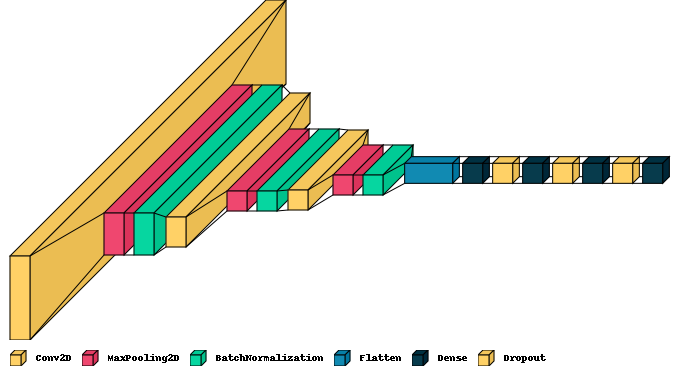

In [206]:
visualkeras.layered_view(model_cnn, legend=True,scale_xy=6)

## Model Training

The loss function for our model is the sparse categorical crossentropy, which is a variant of th categorical cross-entroyp. It is used in cases where the labels are represented as integers instead of one-hot encoded vectors. The predicted output of the model is a probability distribution over the total number of classes, which in this case is 10. The formula for sparse categorical cross-entropy is the following: $H(y, \hat{y}) = -\sum_{i=1}^n y_i \log(\hat{y}_i)$. 

Here $y$ is the true label value of the data and $\hat{y}$ is the predicted probability distribution. $n$ represented the total number of clases and $\hat{y}_i$ is the predicted probability of the $i^{th}$ class. The value of $y_i$ is 1 if $i$ is equal to the true label, meaning the model has correctly identified the song, and 0 otherwise. THe loss is calculated by summing over all the classes and taking the negative log of the predicted probability of the true label. The answer to this shows the differnce beetween the true and predicted probability distribution. The model thus tries to reduce the difference between the predicted value on the actual value of 1.

The optimizer used for the model is Adam, which is an adaptive optimization algorithm for stochastic gradient descent. The optimizer users a moving average of the gradient and the squared gradient to adaptively adjust the learning rate for each parameter. 

The metrics that would be used to test the efficency of the model are the following:
 - Precision: Ratio of true positives to the sum of true positives and false positives. 
 - Recall: Ratio of true positives to the sum of true positives and false negatives.
 - F1 value: Weighted average of precision and recall. Values between 0 and 1.
 - Accuracy: Ratio of the number of correctly classified instances to the total number of instances.


In [292]:
from sklearn.metrics import f1_score

optimiser = keras.optimizers.Adam(learning_rate=0.0001)

def trainmodel(model,epoch,optimizer):
    model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epoch, validation_data=(X_test, y_test))
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, np.argmax(predictions, axis=1), average='weighted')
    return history ,f1
    
#This function plots the accuracy and loss of the model

def plotvalidate(history,f1):
    print("Validation accuracy: ",max(history.history['val_accuracy']))
    print("Training accuracy: ",max(history.history['accuracy']))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

63/63 - 1s - loss: 1.0035 - accuracy: 0.7212 - 724ms/epoch - 11ms/step
63/63 [==============================] - 1s 15ms/step
Precision value 0.7254275925839268
Recall value: 0.7212212212212212
F1 value: 0.7199484472536067
Accuracy value: 0.7212212212212212
Validation accuracy:  0.771271288394928
Training accuracy:  0.8845070600509644


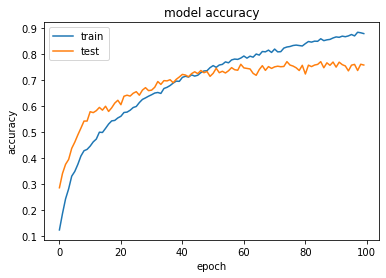

In [293]:
#history, f1 = trainmodel(model_cnn,100,optimiser)

test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
y_pred = model_cnn.predict(X_test)
acc = accuracy_score(y_test, np.argmax(y_pred, axis=1))
f1 = f1_score(y_test, np.argmax(y_pred, axis=1), average='weighted')
recall = recall_score(y_test, np.argmax(y_pred, axis=1), average='weighted')
precision = precision_score(y_test, np.argmax(y_pred, axis=1), average='weighted')
print("Precision value", precision)
print("Recall value:", recall)
print("F1 value:", f1)
print("Accuracy value:", acc)

plotvalidate(history , f1)

## Evaluation 

From the model above, we can see that the values of all the metrics are almost 72%. This is not too good and further improvements can be made.

The model accuracy means that 72% of the time the model correctly identified the classes, out of all the instances.

The recall shows that 72% of the time the model correctly predicted positive classes out of all the instances that truly belonged to the positive class. 

Furthermore, the precision, means that out of all the instances the model predicted as positive 72% of them were actually positive. Finally, the F1 value is comparitively a bit low, 72%, meaning that the model wasnt able to find a very good balance between precision and recall.

## Confusion Matrix

The confusion matrix is a table that is used to evaluate the performance of a classification model. The confusion matrix consists of four different metrics:
   - True positive: The sample was correctly classified positive.
   - False positive: The sample was classified positive but it is negative.
   - True Negative: The sample was correctly classified as negative.
   - False Negative: The sample was classified negative but it is positive.
   
The color intensity of each box represents how effective the model was at making a correct prediction. For example if the box that intersects between the jazz genre is more yellow, it means that the model was correctly able to classify jazz music as jazz. Whereas, the intersection between jazz and metal is dark blue, telling us that there were almost no cases where the model labeled a jazz song as metal. 


Looking at the matrix we can say that in most cases, the model was accuratley able to predict the specific music genre.

In [255]:
import random
y_true_labels = []
y_pred_labels = []


for i in range(1000):
    
    random_number = random.randint(1, 1000)
    
    X_to_predict = X_test[random_number]
    X_to_predict = X_to_predict[np.newaxis, ...]
    y_to_predict = y_test[random_number]
    
    
    y_true_labels.append(y_to_predict)
    
    prediction = model_cnn.predict(X_to_predict)
    predicted_index = np.argmax(prediction)
    
    y_pred_labels.append(predicted_index)

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


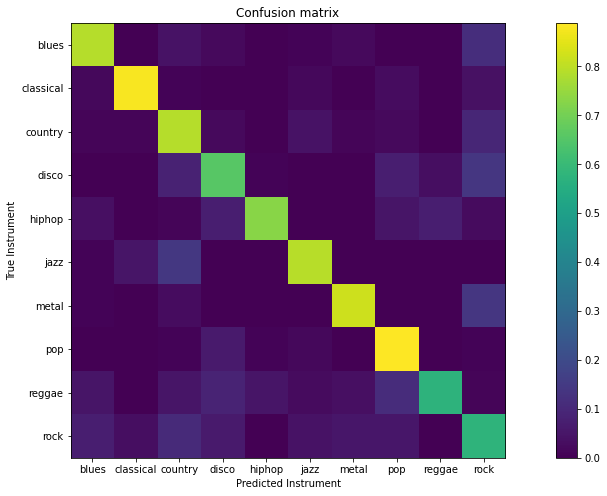

Precision: [0.79147235 0.90417641 0.61934406 0.66574794 0.91543526 0.83423125
 0.87106208 0.72352297 0.84372204 0.50030143]
Recall: [0.79166667 0.88118812 0.78947368 0.65833333 0.73170732 0.79487179
 0.82075472 0.88888889 0.575      0.57894737]
F1 Score: [0.7915695  0.89253427 0.69413639 0.66201988 0.81332446 0.81407606
 0.84516044 0.79772612 0.68391152 0.5367589 ]


In [256]:
cm = confusion_matrix(y_true_labels, y_pred_labels,normalize='true')
fig, ax = plt.subplots(figsize=(18, 8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks(np.arange(10),labels)
plt.yticks(np.arange(10),labels)
plt.xlabel('Predicted Instrument')
plt.ylabel('True Instrument')
plt.show()


precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * precision * recall / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

## Personal Data

Now instead of using the data from the GRATZ dataset, I would be using my personal songs and try to see if the model is able to accuratley predict the genres. I used one song for each genre, for testing purposes. To increase the number of samples, I divided each song into 30 second segments and applied the same feature extraction techniques described above. 



In [257]:
#This code is adapted from the previous assignment 
# Set the folder where the audio files are located
file_path = r"D:\foreign_data"

# Loop through all sub-folders in the directory
for subfile in os.listdir(file_path):

    sub_path = os.path.join(file_path, subfile)
    
    # Check if the sub-folders is a directory and not a file
    if os.path.isdir(sub_path):
        # Loop through all the audio files
        for filename in os.listdir(sub_path):
            # Check if the file is a .wav file
            if filename.endswith(".wav"):
                #Loads the audio file
                audio = AudioSegment.from_wav(os.path.join(sub_path, filename))
                
                # The length of each chunk is set to 30 seconds
                chunk_size = 30000
                
                # Divide the audio into chunks of 30 seconds
                chunks = list(audio[::chunk_size])
                
                # Loop through all the chunks and save them as separate .wav files
                for i, chunk in enumerate(chunks):
                
                    chunk_filename = f"{filename[:-4]}_{i}chunk.wav"
                    
                    # Save the chunk as a .wav file in a new "chunks" directory
                    chunk.export(os.path.join(file_path, sub_path, chunk_filename), format="wav")

In [228]:
JSON_PATH = "outside_data.json"
parent_dir_path =r"D:\foreign_data"

save_mfcc(parent_dir_path, JSON_PATH, num_segments=10)


Processing: D:\foreign_data\blues
D:\foreign_data\blues\blues_0chunk.wav, segment:1
D:\foreign_data\blues\blues_0chunk.wav, segment:2
D:\foreign_data\blues\blues_0chunk.wav, segment:3
D:\foreign_data\blues\blues_0chunk.wav, segment:4
D:\foreign_data\blues\blues_0chunk.wav, segment:5
D:\foreign_data\blues\blues_0chunk.wav, segment:6
D:\foreign_data\blues\blues_0chunk.wav, segment:7
D:\foreign_data\blues\blues_0chunk.wav, segment:8
D:\foreign_data\blues\blues_0chunk.wav, segment:9
D:\foreign_data\blues\blues_0chunk.wav, segment:10
D:\foreign_data\blues\blues_0chunk_0chunk.wav, segment:1
D:\foreign_data\blues\blues_0chunk_0chunk.wav, segment:2
D:\foreign_data\blues\blues_0chunk_0chunk.wav, segment:3
D:\foreign_data\blues\blues_0chunk_0chunk.wav, segment:4
D:\foreign_data\blues\blues_0chunk_0chunk.wav, segment:5
D:\foreign_data\blues\blues_0chunk_0chunk.wav, segment:6
D:\foreign_data\blues\blues_0chunk_0chunk.wav, segment:7
D:\foreign_data\blues\blues_0chunk_0chunk.wav, segment:8
D:\forei

D:\foreign_data\blues\blues_4chunk_0chunk_0chunk.wav, segment:9
D:\foreign_data\blues\blues_4chunk_0chunk_0chunk.wav, segment:10
D:\foreign_data\blues\blues_5chunk.wav, segment:1
D:\foreign_data\blues\blues_5chunk.wav, segment:2
D:\foreign_data\blues\blues_5chunk.wav, segment:3
D:\foreign_data\blues\blues_5chunk.wav, segment:4
D:\foreign_data\blues\blues_5chunk.wav, segment:5
D:\foreign_data\blues\blues_5chunk.wav, segment:6
D:\foreign_data\blues\blues_5chunk.wav, segment:7
D:\foreign_data\blues\blues_5chunk.wav, segment:8
D:\foreign_data\blues\blues_5chunk_0chunk.wav, segment:1
D:\foreign_data\blues\blues_5chunk_0chunk.wav, segment:2
D:\foreign_data\blues\blues_5chunk_0chunk.wav, segment:3
D:\foreign_data\blues\blues_5chunk_0chunk.wav, segment:4


C:\Users\DELL\AppData\Roaming\Python\Python38\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


D:\foreign_data\blues\blues_5chunk_0chunk.wav, segment:5
D:\foreign_data\blues\blues_5chunk_0chunk.wav, segment:6
D:\foreign_data\blues\blues_5chunk_0chunk.wav, segment:7
D:\foreign_data\blues\blues_5chunk_0chunk.wav, segment:8
D:\foreign_data\blues\blues_5chunk_0chunk_0chunk.wav, segment:1
D:\foreign_data\blues\blues_5chunk_0chunk_0chunk.wav, segment:2
D:\foreign_data\blues\blues_5chunk_0chunk_0chunk.wav, segment:3
D:\foreign_data\blues\blues_5chunk_0chunk_0chunk.wav, segment:4
D:\foreign_data\blues\blues_5chunk_0chunk_0chunk.wav, segment:5
D:\foreign_data\blues\blues_5chunk_0chunk_0chunk.wav, segment:6
D:\foreign_data\blues\blues_5chunk_0chunk_0chunk.wav, segment:7
D:\foreign_data\blues\blues_5chunk_0chunk_0chunk.wav, segment:8

Processing: D:\foreign_data\classical
D:\foreign_data\classical\classical_0chunk.wav, segment:1
D:\foreign_data\classical\classical_0chunk.wav, segment:2
D:\foreign_data\classical\classical_0chunk.wav, segment:3
D:\foreign_data\classical\classical_0chunk.wav,

D:\foreign_data\classical\classical_1chunk_0chunk.wav, segment:10
D:\foreign_data\classical\classical_1chunk_0chunk_0chunk.wav, segment:1
D:\foreign_data\classical\classical_1chunk_0chunk_0chunk.wav, segment:2
D:\foreign_data\classical\classical_1chunk_0chunk_0chunk.wav, segment:3
D:\foreign_data\classical\classical_1chunk_0chunk_0chunk.wav, segment:4
D:\foreign_data\classical\classical_1chunk_0chunk_0chunk.wav, segment:5
D:\foreign_data\classical\classical_1chunk_0chunk_0chunk.wav, segment:6
D:\foreign_data\classical\classical_1chunk_0chunk_0chunk.wav, segment:7
D:\foreign_data\classical\classical_1chunk_0chunk_0chunk.wav, segment:8
D:\foreign_data\classical\classical_1chunk_0chunk_0chunk.wav, segment:9
D:\foreign_data\classical\classical_1chunk_0chunk_0chunk.wav, segment:10
D:\foreign_data\classical\classical_2chunk.wav, segment:1
D:\foreign_data\classical\classical_2chunk.wav, segment:2
D:\foreign_data\classical\classical_2chunk.wav, segment:3
D:\foreign_data\classical\classical_2ch

D:\foreign_data\classical\classical_6chunk.wav, segment:1
D:\foreign_data\classical\classical_6chunk.wav, segment:2
D:\foreign_data\classical\classical_6chunk.wav, segment:3
D:\foreign_data\classical\classical_6chunk.wav, segment:4
D:\foreign_data\classical\classical_6chunk.wav, segment:5
D:\foreign_data\classical\classical_6chunk.wav, segment:6
D:\foreign_data\classical\classical_6chunk.wav, segment:7
D:\foreign_data\classical\classical_6chunk.wav, segment:8
D:\foreign_data\classical\classical_6chunk.wav, segment:9
D:\foreign_data\classical\classical_6chunk.wav, segment:10
D:\foreign_data\classical\classical_6chunk_0chunk.wav, segment:1
D:\foreign_data\classical\classical_6chunk_0chunk.wav, segment:2
D:\foreign_data\classical\classical_6chunk_0chunk.wav, segment:3
D:\foreign_data\classical\classical_6chunk_0chunk.wav, segment:4
D:\foreign_data\classical\classical_6chunk_0chunk.wav, segment:5
D:\foreign_data\classical\classical_6chunk_0chunk.wav, segment:6
D:\foreign_data\classical\cla

D:\foreign_data\disco\disco_0chunk.wav, segment:1
D:\foreign_data\disco\disco_0chunk.wav, segment:2
D:\foreign_data\disco\disco_0chunk.wav, segment:3
D:\foreign_data\disco\disco_0chunk.wav, segment:4
D:\foreign_data\disco\disco_0chunk.wav, segment:5
D:\foreign_data\disco\disco_0chunk.wav, segment:6
D:\foreign_data\disco\disco_0chunk.wav, segment:7
D:\foreign_data\disco\disco_0chunk.wav, segment:8
D:\foreign_data\disco\disco_0chunk.wav, segment:9
D:\foreign_data\disco\disco_0chunk.wav, segment:10
D:\foreign_data\disco\disco_0chunk_0chunk.wav, segment:1
D:\foreign_data\disco\disco_0chunk_0chunk.wav, segment:2
D:\foreign_data\disco\disco_0chunk_0chunk.wav, segment:3
D:\foreign_data\disco\disco_0chunk_0chunk.wav, segment:4
D:\foreign_data\disco\disco_0chunk_0chunk.wav, segment:5
D:\foreign_data\disco\disco_0chunk_0chunk.wav, segment:6
D:\foreign_data\disco\disco_0chunk_0chunk.wav, segment:7
D:\foreign_data\disco\disco_0chunk_0chunk.wav, segment:8
D:\foreign_data\disco\disco_0chunk_0chunk.w

D:\foreign_data\disco\disco_3chunk.wav, segment:8
D:\foreign_data\disco\disco_3chunk.wav, segment:9
D:\foreign_data\disco\disco_3chunk.wav, segment:10
D:\foreign_data\disco\disco_3chunk_0chunk.wav, segment:1
D:\foreign_data\disco\disco_3chunk_0chunk.wav, segment:2
D:\foreign_data\disco\disco_3chunk_0chunk.wav, segment:3
D:\foreign_data\disco\disco_3chunk_0chunk.wav, segment:4
D:\foreign_data\disco\disco_3chunk_0chunk.wav, segment:5
D:\foreign_data\disco\disco_3chunk_0chunk.wav, segment:6
D:\foreign_data\disco\disco_3chunk_0chunk.wav, segment:7
D:\foreign_data\disco\disco_3chunk_0chunk.wav, segment:8
D:\foreign_data\disco\disco_3chunk_0chunk.wav, segment:9
D:\foreign_data\disco\disco_3chunk_0chunk.wav, segment:10
D:\foreign_data\disco\disco_3chunk_0chunk_0chunk.wav, segment:1
D:\foreign_data\disco\disco_3chunk_0chunk_0chunk.wav, segment:2
D:\foreign_data\disco\disco_3chunk_0chunk_0chunk.wav, segment:3
D:\foreign_data\disco\disco_3chunk_0chunk_0chunk.wav, segment:4
D:\foreign_data\disco\

D:\foreign_data\disco\disco_8chunk.wav, segment:2
D:\foreign_data\disco\disco_8chunk.wav, segment:3
D:\foreign_data\disco\disco_8chunk.wav, segment:4
D:\foreign_data\disco\disco_8chunk.wav, segment:5
D:\foreign_data\disco\disco_8chunk.wav, segment:6
D:\foreign_data\disco\disco_8chunk.wav, segment:7
D:\foreign_data\disco\disco_8chunk.wav, segment:8
D:\foreign_data\disco\disco_8chunk.wav, segment:9
D:\foreign_data\disco\disco_8chunk.wav, segment:10
D:\foreign_data\disco\disco_8chunk_0chunk.wav, segment:1
D:\foreign_data\disco\disco_8chunk_0chunk.wav, segment:2
D:\foreign_data\disco\disco_8chunk_0chunk.wav, segment:3
D:\foreign_data\disco\disco_8chunk_0chunk.wav, segment:4
D:\foreign_data\disco\disco_8chunk_0chunk.wav, segment:5
D:\foreign_data\disco\disco_8chunk_0chunk.wav, segment:6
D:\foreign_data\disco\disco_8chunk_0chunk.wav, segment:7
D:\foreign_data\disco\disco_8chunk_0chunk.wav, segment:8
D:\foreign_data\disco\disco_8chunk_0chunk.wav, segment:9
D:\foreign_data\disco\disco_8chunk_0

D:\foreign_data\hiphop\hiphop_3chunk_0chunk.wav, segment:2
D:\foreign_data\hiphop\hiphop_3chunk_0chunk.wav, segment:3
D:\foreign_data\hiphop\hiphop_3chunk_0chunk.wav, segment:4
D:\foreign_data\hiphop\hiphop_3chunk_0chunk.wav, segment:5
D:\foreign_data\hiphop\hiphop_3chunk_0chunk.wav, segment:6
D:\foreign_data\hiphop\hiphop_3chunk_0chunk.wav, segment:7
D:\foreign_data\hiphop\hiphop_3chunk_0chunk.wav, segment:8
D:\foreign_data\hiphop\hiphop_3chunk_0chunk.wav, segment:9
D:\foreign_data\hiphop\hiphop_3chunk_0chunk.wav, segment:10
D:\foreign_data\hiphop\hiphop_3chunk_0chunk_0chunk.wav, segment:1
D:\foreign_data\hiphop\hiphop_3chunk_0chunk_0chunk.wav, segment:2
D:\foreign_data\hiphop\hiphop_3chunk_0chunk_0chunk.wav, segment:3
D:\foreign_data\hiphop\hiphop_3chunk_0chunk_0chunk.wav, segment:4
D:\foreign_data\hiphop\hiphop_3chunk_0chunk_0chunk.wav, segment:5
D:\foreign_data\hiphop\hiphop_3chunk_0chunk_0chunk.wav, segment:6
D:\foreign_data\hiphop\hiphop_3chunk_0chunk_0chunk.wav, segment:7
D:\for

D:\foreign_data\hiphop\hiphop_8chunk.wav, segment:2
D:\foreign_data\hiphop\hiphop_8chunk.wav, segment:3
D:\foreign_data\hiphop\hiphop_8chunk.wav, segment:4
D:\foreign_data\hiphop\hiphop_8chunk.wav, segment:5
D:\foreign_data\hiphop\hiphop_8chunk.wav, segment:6
D:\foreign_data\hiphop\hiphop_8chunk.wav, segment:7
D:\foreign_data\hiphop\hiphop_8chunk.wav, segment:8
D:\foreign_data\hiphop\hiphop_8chunk.wav, segment:9
D:\foreign_data\hiphop\hiphop_8chunk.wav, segment:10
D:\foreign_data\hiphop\hiphop_8chunk_0chunk.wav, segment:1
D:\foreign_data\hiphop\hiphop_8chunk_0chunk.wav, segment:2
D:\foreign_data\hiphop\hiphop_8chunk_0chunk.wav, segment:3
D:\foreign_data\hiphop\hiphop_8chunk_0chunk.wav, segment:4
D:\foreign_data\hiphop\hiphop_8chunk_0chunk.wav, segment:5
D:\foreign_data\hiphop\hiphop_8chunk_0chunk.wav, segment:6
D:\foreign_data\hiphop\hiphop_8chunk_0chunk.wav, segment:7
D:\foreign_data\hiphop\hiphop_8chunk_0chunk.wav, segment:8
D:\foreign_data\hiphop\hiphop_8chunk_0chunk.wav, segment:9


D:\foreign_data\pop\pop_2chunk_0chunk_0chunk.wav, segment:4
D:\foreign_data\pop\pop_2chunk_0chunk_0chunk.wav, segment:5
D:\foreign_data\pop\pop_2chunk_0chunk_0chunk.wav, segment:6
D:\foreign_data\pop\pop_2chunk_0chunk_0chunk.wav, segment:7
D:\foreign_data\pop\pop_2chunk_0chunk_0chunk.wav, segment:8
D:\foreign_data\pop\pop_2chunk_0chunk_0chunk.wav, segment:9
D:\foreign_data\pop\pop_2chunk_0chunk_0chunk.wav, segment:10
D:\foreign_data\pop\pop_3chunk.wav, segment:1
D:\foreign_data\pop\pop_3chunk.wav, segment:2
D:\foreign_data\pop\pop_3chunk.wav, segment:3
D:\foreign_data\pop\pop_3chunk.wav, segment:4
D:\foreign_data\pop\pop_3chunk.wav, segment:5
D:\foreign_data\pop\pop_3chunk.wav, segment:6
D:\foreign_data\pop\pop_3chunk.wav, segment:7
D:\foreign_data\pop\pop_3chunk.wav, segment:8
D:\foreign_data\pop\pop_3chunk.wav, segment:9
D:\foreign_data\pop\pop_3chunk.wav, segment:10
D:\foreign_data\pop\pop_3chunk_0chunk.wav, segment:1
D:\foreign_data\pop\pop_3chunk_0chunk.wav, segment:2
D:\foreign_d


Processing: D:\foreign_data\reggae
D:\foreign_data\reggae\regge_0chunk.wav, segment:1
D:\foreign_data\reggae\regge_0chunk.wav, segment:2
D:\foreign_data\reggae\regge_0chunk.wav, segment:3
D:\foreign_data\reggae\regge_0chunk.wav, segment:4
D:\foreign_data\reggae\regge_0chunk.wav, segment:5
D:\foreign_data\reggae\regge_0chunk_0chunk.wav, segment:1
D:\foreign_data\reggae\regge_0chunk_0chunk.wav, segment:2
D:\foreign_data\reggae\regge_0chunk_0chunk.wav, segment:3
D:\foreign_data\reggae\regge_0chunk_0chunk.wav, segment:4
D:\foreign_data\reggae\regge_0chunk_0chunk.wav, segment:5
D:\foreign_data\reggae\regge_0chunk_0chunk_0chunk.wav, segment:1
D:\foreign_data\reggae\regge_0chunk_0chunk_0chunk.wav, segment:2
D:\foreign_data\reggae\regge_0chunk_0chunk_0chunk.wav, segment:3
D:\foreign_data\reggae\regge_0chunk_0chunk_0chunk.wav, segment:4
D:\foreign_data\reggae\regge_0chunk_0chunk_0chunk.wav, segment:5

Processing: D:\foreign_data\rock
D:\foreign_data\rock\rock.mp3, segment:1
D:\foreign_data\roc

In [258]:
X, y = load_data(data)


Data succesfully loaded!


In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets to convert it into a 4D- tensor
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# (sample_size, height, width, number_of_channels)

input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [294]:


y_pred = model_cnn.predict(X_test)
acc = accuracy_score(y_test, np.argmax(y_pred, axis=1))
f1 = f1_score(y_test, np.argmax(y_pred, axis=1), average='weighted')
recall = recall_score(y_test, np.argmax(y_pred, axis=1), average='weighted')
precision = precision_score(y_test, np.argmax(y_pred, axis=1), average='weighted')
print("Precision value", precision)
print("Recall value:", recall)
print("F1 value:", f1)
print("Accuracy value:", acc)

63/63 [==============================] - 1s 12ms/step
Precision value 0.7254275925839268
Recall value: 0.7212212212212212
F1 value: 0.7199484472536067
Accuracy value: 0.7212212212212212


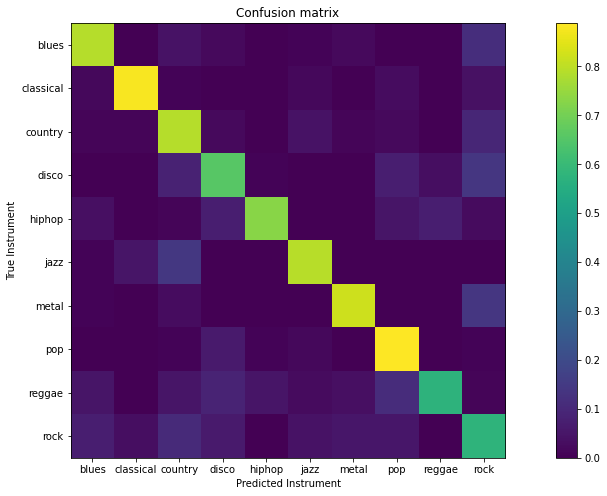

Precision: [0.79147235 0.90417641 0.61934406 0.66574794 0.91543526 0.83423125
 0.87106208 0.72352297 0.84372204 0.50030143]
Recall: [0.79166667 0.88118812 0.78947368 0.65833333 0.73170732 0.79487179
 0.82075472 0.88888889 0.575      0.57894737]
F1 Score: [0.7915695  0.89253427 0.69413639 0.66201988 0.81332446 0.81407606
 0.84516044 0.79772612 0.68391152 0.5367589 ]


In [266]:
cm = confusion_matrix(y_true_labels, y_pred_labels,normalize='true')
fig, ax = plt.subplots(figsize=(18, 8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks(np.arange(10),labels)
plt.yticks(np.arange(10),labels)
plt.xlabel('Predicted Instrument')
plt.ylabel('True Instrument')
plt.show()


precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * precision * recall / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

## Discussion

We can see that our model performed really well on foreign data, which is evident by the high scores on all model evaluation metrics. 

We can see that the model has an accuracy score of 87%. It means that 87% of the time the model correctly identified the classes, out of all the instances.

The recall is also 87%, which shows the percentage that the model correctly predicted positive classes out of all the instances that truly belonged to the positive class. 

Furthermore, the precision is 87%, meaning that out of all the instances the model predicted as positive 87% of them were actually positive. Finally, the F1 value is comparitively a bit low, 72%, meaning that the model wasnt able to find a very good balance between precision and recall.

## Further Improvements

Currently the model is not optimal as we can see that it is still wrongly predicting some songs. To increase the robustness and efficiency of the model, following steps can be takes:

- Data Augmentation: It is a process of increasing hte size and idveristy of the training set by applying various transformations to the existing data. For example, we could add white noise, change the speed of the sample, change the pitch etc. This step would help reduce overfitting and increase the generalizability of the model.
- Adjust Hyperparameters: The hyperparameters for the model include the number of layers, the number of filter, the learning rate etc. By experimenting with different values we can improve thee model's accuracy.
- Regularization: L2 regularization along with droupout was implemented in the model. Further fine tuning of these parameters can lead to increased efficiency.
- Ensembling: This is a process where we combine the prediction of multiple models and use the one with the most desirable results. This is done by averaging the outputs of different models and choosing the one with the best result.

## Executive Summary


For this assignment, I implemented a Convolutional Neural Network which would be used to classify music genres. The training data was the GTZAN music dataset which contained 10 music genres, each contaiing 100 samples. Each sample was 30 seconds long.

First a pie chart was created to identify the class imbalances. All the data was equally distributed thus no pre-processing was needed at this stage. Next, the audio samples were visualized and the process of data conversion was discussed. From the audio data Mel-frequency cepstrum coeffecient values were extracted from each file. 

After this the data was divided into three section: the training, test, and validation set. The CNN model was then described and constructed. The model was trained on the pre-processed data and the final model was evaluatied on the following metrics: recall, accuracy, F1 score, and precision.

After this the model was tested on personal data, the was evaluated using the same metrics. Finally improvements were discussed to make the model more accurate and robust to new daata.

## Citation

Most of my work was influenced by the following Youtube channel. It provided numerous examples and detailed lectures on how audio data can be represented for machine learning, and what steps can be taken for data pre-processing. 
- https://www.youtube.com/@ValerioVelardoTheSoundofAI


- Team, T. A. I. (2022, March 24). Deep learning simplified: Feel and talk like an expert in neural... Towards AI. Retrieved March 27, 2023, from https://towardsai.net/p/deep-learning/deep-learning-simplified-feel-and-talk-like-an-expert-in-neural-networks 
